In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import arch
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters() 

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
universe = {'Equities': {'IVV': 'S&P 500', 'QQQ': 'Nasdaq', 'IWM': 'Russel 2000', 'DVY': 'US Dividend', 'EZU': 'Europe'}, #, IVV=SPY but cheaper    'DIA': 'Dow Jones',
           'Commodities': {'IAU': 'Gold', 'USO' : 'Oil'}, # 'SLV': 'Silver', 'USO': 'Oil', 'DBA': 'Agriculture', 'DBB': 'Base Metals', 'DBP': 'Precious Metals', 'DBO': 'Oil', 'DBC': 'Commodities' #IAU = GLD but cheaper
           'FixedIncome' : {'TLT': 'Long Term', 'AGG': 'Aggregate'}, # IEF: intermediate term
           #'REIT' : {'VNQ': 'US REIT'}
           }
symbols = [symbol for asset in universe.values() for symbol in asset.keys()]
tickers = [yf.Ticker(symbol) for symbol in symbols]

In [3]:
special_exchanges = {}

In [4]:
exchanges = {}
for symbol in symbols:
    exchanges[symbol] = 'SMART' if not symbol in special_exchanges else special_exchanges[symbol]

In [5]:
def get_data(ticker):
    data = ticker.history(period='max')
    return data['Close'].rename(ticker.ticker)

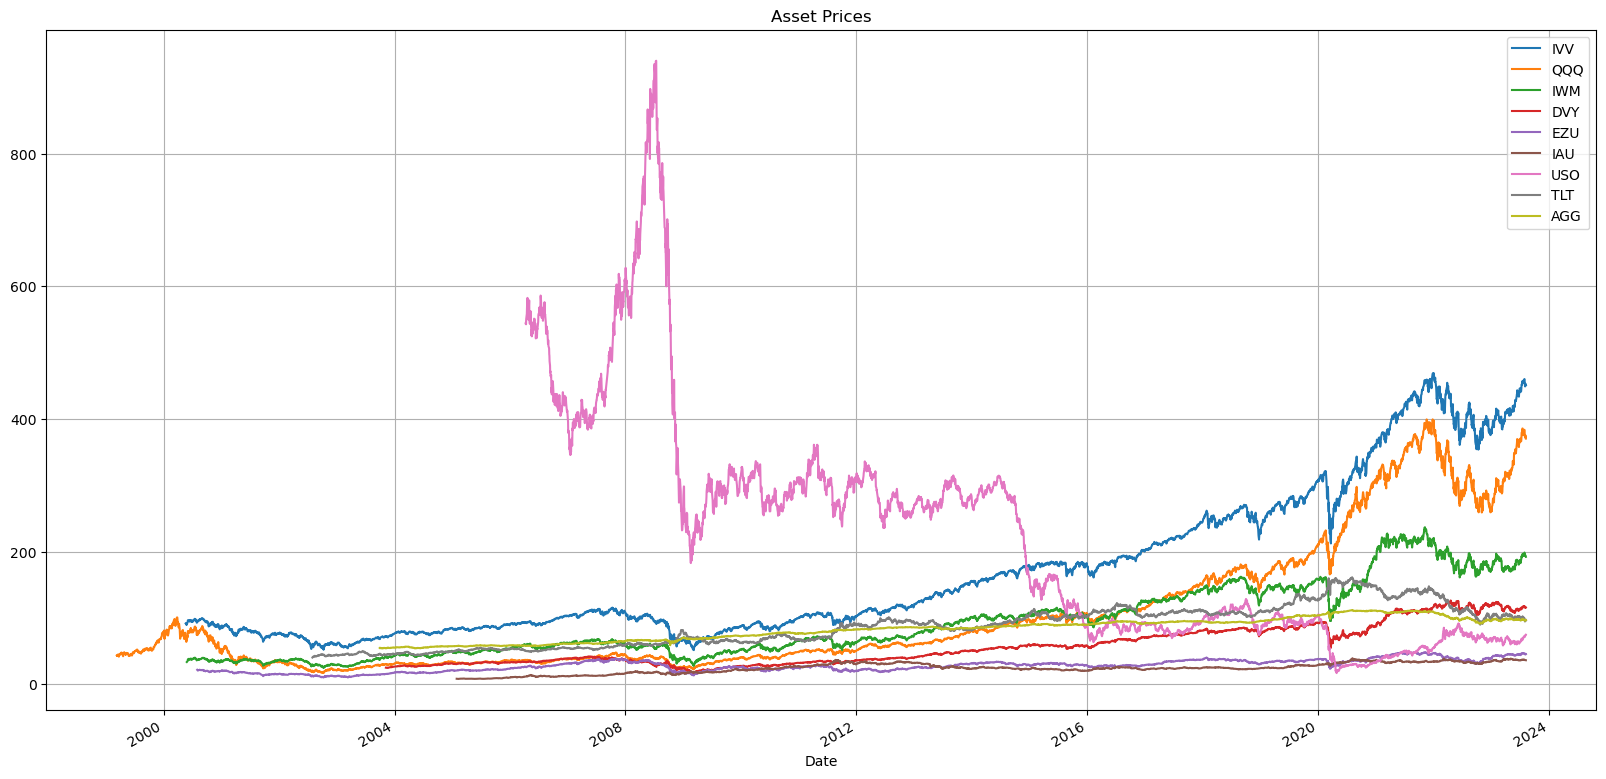

In [6]:
prices = pd.DataFrame({symbol.ticker: get_data(symbol) for symbol in tickers})
prices.plot(figsize=(20,10), grid=True, title='Asset Prices');

<Axes: >

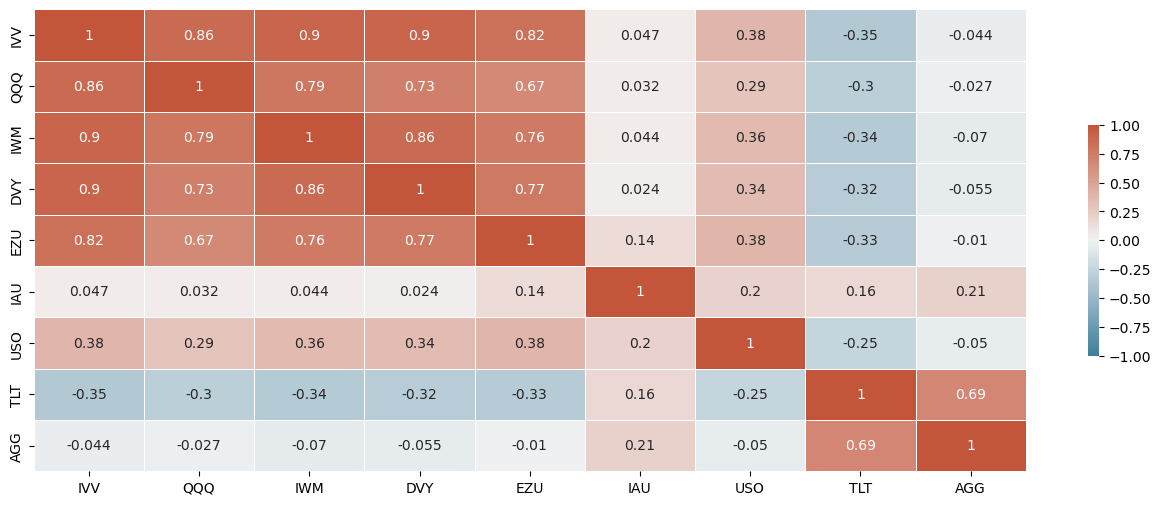

In [7]:
import seaborn as sns
corr = prices.pct_change().corr()
f, ax = plt.subplots(figsize=(16, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [8]:
vix = get_data(yf.Ticker('VIX')).resample('D').last().ffill()
vix.index = pd.to_datetime(vix.index).date
vix.index = pd.to_datetime(vix.index)

In [9]:
max([prices[col].first_valid_index() for col in prices.columns])

Timestamp('2006-04-10 00:00:00-0400', tz='America/New_York')

In [10]:
prices = prices[max([prices[col].first_valid_index() for col in prices.columns]):].dropna(axis=1)
prices.index = pd.to_datetime(prices.index).date
prices.index = pd.to_datetime(prices.index)
prices = prices.resample('B').last().ffill().fillna(method='ffill')
full_df = prices.copy()

In [11]:
prices/=prices.iloc[0]

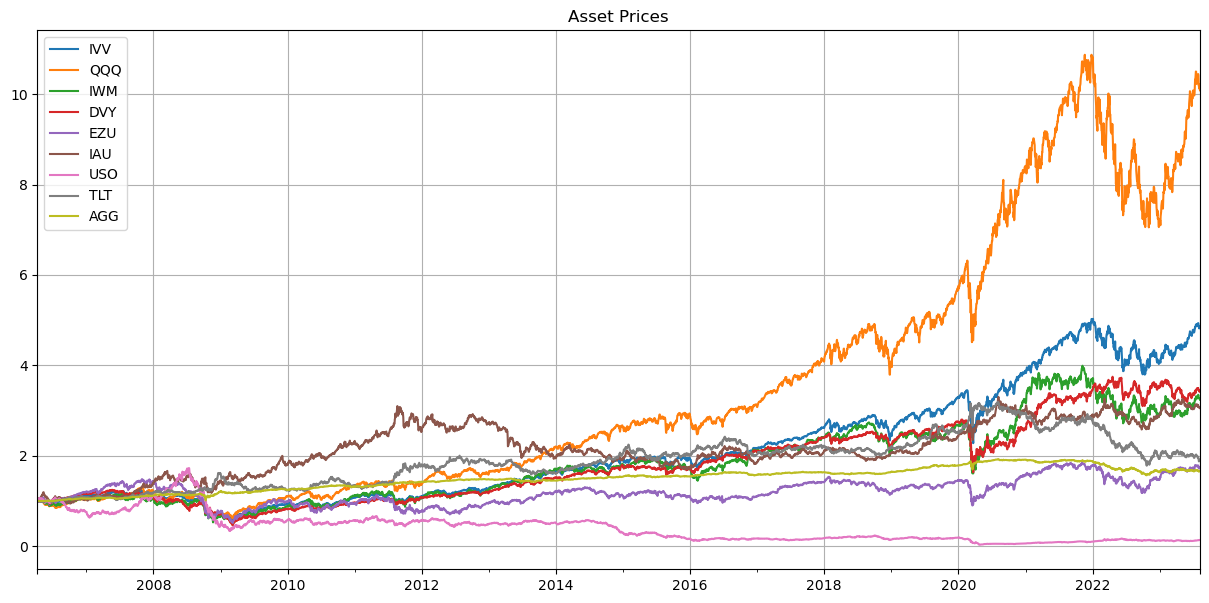

In [12]:
prices.plot(figsize=(15,7), grid=True, title='Asset Prices');

In [13]:
from scipy.stats import t
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import Bounds

class RiskMeasures:
    
    def __init__(self, confidence_level):
        self._confidence_level = confidence_level
    
    def value_at_risk(self, returns):
        return returns.quantile(self._confidence_level)

    def gaussian_var(self, returns):
        z = norm.ppf(self._confidence_level)
        s = returns.skew()
        k = returns.kurtosis()
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        return (returns.mean() + z*returns.std(ddof=0))
        
    def expected_shortfall(self, returns):
        returns = returns[returns!=0]
        var = self.value_at_risk(returns)
        return abs(returns[returns.lt(var)].mean())

In [14]:
def rolling_cvar(rets):
    rm = RiskMeasures(confidence_level=0.05)
    risk_strategy = rm.expected_shortfall(returns=rets)
    return risk_strategy

In [15]:
import scipy.cluster.hierarchy as hierarchy
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import pdist, squareform
#https://research-api.cbs.dk/ws/portalfiles/portal/62178444/879726_Master_Thesis_Nima_Daniel_15736.pdf
#https://github.com/dcajasn/Riskfolio-Lib/blob/d2e7714a7e37839037e46c93fc1149931136d9e6/riskfolio/HCPortfolio.py#L199

class HierarchicalEqualRiskContribution:
    
    def __init__(self):
    
        self.weights = None
        self.asset_order = None
        self.clusters = None
        self.corr = None
        self.corr_sorted = None
        self.min_risk = None
        self.max_risk = None
                
    # get inverse-variance/volatility weights
    def inv_var(self, returns, cov, risk_lookback, w_method='var', confidence_level=0.05):
        cov = pd.DataFrame(cov)        
        assets = cov.columns.tolist()
        n = len(assets)
        sr = RiskMeasures(confidence_level=confidence_level)
        
        if w_method == 'var':
            inv_diag = 1 / np.diag(cov.values)
        elif w_method == 'vol':
            inv_diag = 1 / np.sqrt(np.diag(cov.values))
        
        elif w_method in ['cvar', 'gvar', 'mad']:
            inv_diag = np.zeros((n, 1))
            for i in assets:
                k = assets.index(i)
                if w_method == 'cvar':
                    risk_strategy = sr.expected_shortfall(returns=returns[i][-risk_lookback:])

                    if not self.min_risk is None:
                        risk = max(self.min_risk, risk_strategy)
                    else:
                        risk = risk_strategy
                        
                    if not self.max_risk is None:
                        risk = min(self.max_risk, risk)
                    
                    print(i,risk)

                inv_diag[k, 0] = 1 / risk
        
        weight = inv_diag * (1 / np.sum(inv_diag))
        weight = weight.reshape(-1,1)
        return weight
    
    def hierarchical_clustering(self, corr, linkage, max_k, leaf_order=True):
        
        # hierarchcial clustering
        dist = np.sqrt((1 - corr).round(5) / 2)
        dist = pd.DataFrame(dist, columns=corr.columns, index=corr.index)
        p_dist = pdist(dist)
        clustering = hierarchy.linkage(p_dist, method=linkage, optimal_ordering=leaf_order)
        
        # cluster levels over from 1 to N-1 clusters
        cluster_lvls = pd.DataFrame(hierarchy.cut_tree(clustering), index=corr.columns)
        num_k = cluster_lvls.columns # save column with number of clusters
        cluster_lvls = cluster_lvls.iloc[:, ::-1] # reverse order to start with,→ 1 cluster
        cluster_lvls.columns = num_k # set columns to number of cluster
        W_list = []
        
        for k in range(min(len(cluster_lvls.columns), max_k)):
            level = cluster_lvls.iloc[:,k] # get k clusters
            D_list = [] # within-cluster distance list
            
            for i in range(np.max(level.unique())+1):
                cluster = level.loc[level == i] 
                # Based on correlation distance 
                cluster_dist = dist.loc[cluster.index, cluster.index] # get distance
                cluster_pdist = pdist(cluster_dist) # flatten and transform to squared euclidean
                D = np.nan_to_num(cluster_pdist.std())
                D_list.append(D) # append to list
                
            W_k = np.sum(D_list)
            W_list.append(W_k)
        
        W_list = pd.Series(W_list)
        n = corr.shape[0]
        limit_k = int(min(max_k, np.sqrt(n)))
        gaps = W_list.shift(-2) + W_list - 2*W_list.shift(-1)
        gaps = gaps[0:limit_k]
        k = gaps.idxmax() + 2
        
        return clustering, k
    
    def seriation(self, clusters):
        return hierarchy.leaves_list(clusters)
    
    def hierarchical_recursive_bisection(self, cov, linkage, k, w_method, returns, risk_lookback, confidence_level):
        # Transform linkage to tree and reverse order
        root, nodes = hierarchy.to_tree(linkage, rd=True)
        nodes = nodes[::-1]
        items = pd.Series(data=hierarchy.leaves_list(linkage)) # Get list of assets
        weight = pd.Series(1, index=cov.index) # Set initial weights to 1
        
        # Loop through k clusters
        for i in nodes[:k-1]:
            if i.is_leaf() == False: # skip leaf-nodes
                left = i.get_left().pre_order() # lambda i: i.id get left cluster
                right = i.get_right().pre_order() # lambda i: i.id get right cluster
                
                # Left cluster
                left_cov = cov.iloc[left, left]
                left_weight = self.inv_var(returns, left_cov, risk_lookback, w_method, confidence_level)
                left_var = np.dot(np.dot(left_weight.T, left_cov), left_weight)[0,0]
                
                # Right cluster
                right_cov = cov.iloc[right, right]
                right_weight = self.inv_var(returns, right_cov, risk_lookback,  w_method, confidence_level)
                right_var = np.dot(np.dot(right_weight.T, right_cov), right_weight)[0,0]
                
                # Allocate weight to clusters
                alpha = 1 - left_var / (left_var + right_var)
                weight[left] *= alpha # weight 1
                weight[right] *= 1 - alpha # weight 2
                
        # Get constituents of k clusters
        clustered_assets = pd.Series(hierarchy.cut_tree(linkage, n_clusters=k).flatten(), index=cov.index)
        w = pd.DataFrame(np.ones(len(cov.index)), index=cov.index)
        
        # Multiply within-cluster weight with inter-cluster weight
        for i in range(k):
            cluster = clustered_assets.loc[clustered_assets == i]
            cluster_cov = cov.loc[cluster.index, cluster.index]
            cluster_weights = pd.Series(self.inv_var(returns, cluster_cov, risk_lookback, w_method, confidence_level).flatten(), index=cluster_cov.index)
            weight.loc[cluster_weights.index] *= cluster_weights
        
        return weight

    def cov2corr(self, cov):
        std = np.sqrt(np.diag(cov))
        corr = cov / np.outer(std, std)
        corr[corr < -1], corr[corr > 1] = -1, 1 #numerical error
        return corr
    
    # Allocate weights
    def allocate(self, cov, returns, risk_lookback, linkage='ward', max_k=20, w_method='var', min_risk = None, max_risk = None, confidence_level = 0.05):
        self.min_risk = min_risk
        self.max_risk = max_risk        
        # Correlation matrix from covariance matrix
        self.corr = self.cov2corr(cov)
        # Step-1: Tree clustering
        self.clusters, self.k, = self.hierarchical_clustering(self.corr, linkage, max_k)
        # Step-2: Seriation (Quasi-Diagnalization)
        self.sort_order = self.seriation(self.clusters)
        asset_order = list(cov.columns)
        asset_order[:] = [asset_order[i] for i in self.sort_order]
        self.asset_order = asset_order
        self.corr_sorted = self.corr.reindex(index=self.asset_order, columns=self.asset_order)
        # Step-3: Recursive Bisection
        self.weights = self.hierarchical_recursive_bisection(cov, self.clusters, self.k, w_method, returns, risk_lookback, confidence_level)
        return self.weights

In [16]:
from dateutil.relativedelta import relativedelta
def get_market_weights(d=None, cov_min = -0.5, cov_max = 0.5, risk_lookback = 52, w_method = 'cvar', max_k = 10, min_risk = 2.5, max_risk = 9, return_lookback_years = None, return_decay = None):
    
    if return_decay is None:
        returns = np.log(full_df.resample('W').last()).diff().fillna(method='ffill').fillna(0)*100
    else:
        returns = np.log(full_df.ewm(alpha=1-return_decay).mean().resample('W').last()).diff().fillna(method='ffill').fillna(0)*100
    start_date = d - relativedelta(years = return_lookback_years) if return_lookback_years is not None else returns.first_valid_index()

    if d is not None:
        returns = returns[start_date:d-relativedelta(days=1)]
        
    corr = returns.corr()
    cov = returns.cov()
    covc = np.minimum(cov_max, np.maximum(cov_min, cov))
    
    hrc = HierarchicalEqualRiskContribution()
    herc = hrc.allocate(cov=covc, returns=returns, max_k=max_k, w_method=w_method, risk_lookback=risk_lookback, min_risk = min_risk, max_risk = max_risk)
    
    ivp = 1 / np.diag(covc)
    ivp /= ivp.sum()
    
    return herc, ivp

In [17]:
dates = pd.date_range(datetime.datetime(2008,1,1), datetime.datetime.now(), freq='M')[1:]

In [18]:
herc_settings = dict(cov_min = -1, cov_max = 1, risk_lookback = 52, w_method = 'cvar', max_k = 3, min_risk = 2.5, max_risk = 10, return_lookback_years = 10)

In [19]:
wfwds = [get_market_weights(d=d.date(), 
                            cov_min = herc_settings['cov_min'], 
                            cov_max = herc_settings['cov_max'],  
                            risk_lookback = herc_settings['risk_lookback'], 
                            w_method = herc_settings['w_method'], 
                            max_k = herc_settings['max_k'], 
                            min_risk = herc_settings['min_risk'], 
                            max_risk = herc_settings['max_risk'], 
                            return_lookback_years = herc_settings['return_lookback_years']) 
            for d in dates]

dfw_herc = pd.DataFrame([w[0] for w in wfwds], index=dates) 
dfw_ivp = pd.DataFrame([w[1] for w in wfwds], index=dates, columns = dfw_herc.columns)
#wdf = dfw_herc.resample('B').last().ffill()
#ivp = dfw_ivp.resample('B').last().ffill()

QQQ 7.212512893789865
DVY 5.928458596726334
IVV 5.247100512293024
IWM 6.904747056254212
EZU 6.9706800428768645
IAU 5.7093072795637285
USO 7.344574318397997
TLT 2.5
AGG 2.5
IVV 5.247100512293024
QQQ 7.212512893789865
IWM 6.904747056254212
DVY 5.928458596726334
EZU 6.9706800428768645
IAU 5.7093072795637285
USO 7.344574318397997
TLT 2.5
AGG 2.5
QQQ 6.587224924184066
DVY 5.928458596726334
IVV 5.2470168433264535
IWM 6.703483905276138
EZU 6.7025673289564365
IAU 6.799222654010369
USO 7.543981366071891
AGG 2.5
TLT 2.5
IVV 5.2470168433264535
QQQ 6.587224924184066
IWM 6.703483905276138
DVY 5.928458596726334
EZU 6.7025673289564365
IAU 6.799222654010369
USO 7.543981366071891
TLT 2.5
AGG 2.5
QQQ 6.587224924184066
DVY 5.928458596726334
IVV 5.2470168433264535
IWM 6.703483905276138
EZU 6.7025673289564365
IAU 6.799222654010369
USO 7.543981366071891
AGG 2.5
TLT 2.5924645395445958
IVV 5.2470168433264535
QQQ 6.587224924184066
IWM 6.703483905276138
DVY 5.928458596726334
EZU 6.7025673289564365
IAU 6.7992226

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IWM 10
DVY 10
EZU 10
USO 10
AGG 5.00405802043975
IAU 8.580316800477911
TLT 3.206832068724571
AGG 5.00405802043975
IVV 10
DVY 10
QQQ 10
IWM 10
EZU 10
USO 10
IAU 8.580316800477911
TLT 3.1283846703016907
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 5.00405802043975
IAU 8.580316800477911
TLT 3.1283846703016907
AGG 5.00405802043975
QQQ 10
DVY 10
IVV 10
IWM 10
EZU 10
USO 10
IAU 8.580316800477911
TLT 4.634793158535366
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 5.00405802043975


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IAU 8.580316800477911
TLT 4.634793158535366
AGG 5.00405802043975
IWM 10
IVV 10
DVY 10
QQQ 10
EZU 10
USO 10
IAU 8.580316800477911
TLT 4.634793158535366
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 5.00405802043975
IAU 8.580316800477911
TLT 4.634793158535366
AGG 5.00405802043975
IWM 10
IVV 10
DVY 10
QQQ 10
EZU 10
USO 10
IAU 7.8553908216546136
TLT 4.634793158535366
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 5.00405802043975
IAU 7.8553908216546136
TLT 4.634793158535366
AGG 5.00405802043975
IWM 10
IVV 10
DVY 10
QQQ 10
EZU 10
USO 10
IAU 7.8553908216546136
TLT 4.634793158535366
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 5.00405802043975
IAU 7.8553908216546136
TLT 4.634793158535366
AGG 5.00405802043975
IWM 10
IVV 10
DVY 10
QQQ 10
EZU 10
USO 10
IAU 7.8553908216546136
TLT 4.927282045473606
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 5.00405802043975
IAU 7.8553908216546136
TLT 4.927282045473606
AGG 4.957041864561636
IWM 10
IVV 10
DVY 10
QQQ 10
EZU 10
USO 10
IAU 7.8553908216546136
TLT 5.0

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

AGG 4.957041864561636
IWM 10
IVV 10
DVY 10
QQQ 10
EZU 10
USO 10
IAU 7.8553908216546136
TLT 5.33043496443512
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 4.957041864561636
IAU 7.8553908216546136
TLT 5.33043496443512
AGG 4.957041864561636
DVY 10
IVV 10
IWM 10
QQQ 10
EZU 10
USO 10
IAU 7.2315396217330035
TLT 5.33043496443512
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 4.957041864561636
IAU 7.2315396217330035
TLT 5.33043496443512
AGG 4.737545766664268
DVY 10
IVV 10
IWM 10
QQQ 10
EZU 10
USO 10
IAU 7.2315396217330035
TLT 5.33043496443512
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
AGG 4.737545766664268
IAU 7.2315396217330035
TLT 5.33043496443512
AGG 2.5
DVY 10
IVV 7.559217417999904
IWM 10
QQQ 6.98763501782076
EZU 9.33966701861412
USO 10
IAU 5.424669327282717
TLT 5.33043496443512
IVV 7.559217417999904
QQQ 6.98763501782076
IWM 10
DVY 10
EZU 9.33966701861412
USO 10
AGG 2.5
IAU 5.424669327282717
TLT 5.33043496443512
AGG 2.5
DVY 9.020664929477048
IVV 6.317944413443459
IWM 8.483618289994391
QQQ 5.

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

AGG 2.5
DVY 9.020664929477048
IVV 6.317944413443459
IWM 8.483618289994391
QQQ 5.059181165058628
EZU 8.065498179110056
USO 10
IAU 4.335149209054083
TLT 4.805678677045074
IVV 6.317944413443459
QQQ 5.059181165058628
IWM 8.483618289994391
DVY 9.020664929477048
EZU 8.065498179110056
USO 10
AGG 2.5
IAU 4.335149209054083
TLT 4.805678677045074
AGG 2.5
DVY 7.030947736829522
IVV 5.522664415644425
QQQ 4.828565328550916
IWM 7.876809206512296
EZU 7.274358974671709
USO 9.080833282743406
IAU 4.335149209054083
TLT 4.805678677045074
IVV 5.522664415644425
QQQ 4.828565328550916
IWM 7.876809206512296
DVY 7.030947736829522
EZU 7.274358974671709
USO 9.080833282743406
AGG 2.5
IAU 4.335149209054083
TLT 4.805678677045074
AGG 2.5
DVY 4.673938277825303
QQQ 4.023109733451295
IVV 4.288554866015233
IWM 5.562984491475905
EZU 7.059928256592866
USO 9.080833282743406
IAU 3.664425050310601
TLT 4.805678677045074
IVV 4.288554866015233
QQQ 4.023109733451295
IWM 5.562984491475905
DVY 4.673938277825303
EZU 7.059928256592866


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

AGG 2.5
DVY 5.066093060578621
QQQ 6.548111396951543
IVV 5.4967959019514305
IWM 7.75541209295687
USO 10
EZU 9.536979471153431
IAU 4.030269239883981
TLT 3.6315864930425454
IVV 5.4967959019514305
QQQ 6.548111396951543
IWM 7.75541209295687
DVY 5.066093060578621
EZU 9.536979471153431
USO 10
AGG 2.5
IAU 4.030269239883981
TLT 3.6315864930425454
EZU 9.747437696334343
USO 10
IWM 7.75541209295687
IVV 5.4967959019514305
QQQ 6.548111396951543
DVY 5.066093060578621
IAU 4.030269239883981
AGG 2.5
TLT 3.158217216686765
IVV 5.4967959019514305
QQQ 6.548111396951543
IWM 7.75541209295687
DVY 5.066093060578621
EZU 9.747437696334343
USO 10
IAU 4.030269239883981
TLT 3.158217216686765
AGG 2.5
EZU 9.747437696334343
USO 9.882553293092075
IWM 7.75541209295687
IVV 5.4967959019514305
QQQ 6.548111396951543
DVY 5.066093060578621
IAU 4.030269239883981
AGG 2.5
TLT 3.158217216686765
IVV 5.4967959019514305
QQQ 6.548111396951543
IWM 7.75541209295687
DVY 5.066093060578621
EZU 9.747437696334343
USO 9.882553293092075
IAU 4.

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 5.066093060578621
QQQ 6.345914242922258
IVV 5.4967959019514305
IWM 7.75541209295687
USO 9.83265123979867
EZU 9.493913785565484
IAU 3.926167861662385
AGG 2.5
TLT 3.1639525358496456
IVV 5.4967959019514305
QQQ 6.345914242922258
IWM 7.75541209295687
DVY 5.066093060578621
EZU 9.493913785565484
USO 9.83265123979867
IAU 3.926167861662385
TLT 3.1639525358496456
AGG 2.5
DVY 3.482715075805768
QQQ 4.7997317937561235
IVV 4.184388231374392
IWM 6.035206065883821
USO 10
EZU 6.579310623568283
IAU 4.025473266590603
AGG 2.5
TLT 3.1639525358496456
IVV 4.184388231374392
QQQ 4.7997317937561235
IWM 6.035206065883821
DVY 3.482715075805768
EZU 6.579310623568283
USO 10
IAU 4.025473266590603
TLT 3.1639525358496456
AGG 2.5
DVY 3.260686184739218
QQQ 4.794147980050208
IVV 3.809625778228328
IWM 6.035206065883821
USO 10
EZU 6.579310623568283
IAU 4.025473266590603
AGG 2.5
TLT 3.1639525358496456
IVV 3.809625778228328
QQQ 4.794147980050208
IWM 6.035206065883821
DVY 3.260686184739218
EZU 6.579310623568283
USO 10
IAU

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 4.070079889392823
QQQ 5.944982236269233
IVV 5.3904986403447985
IWM 7.696677482226792
EZU 7.930390472945393
USO 10
IAU 3.82191881801582
AGG 2.5
TLT 3.376370398877141
IVV 5.3904986403447985
QQQ 5.944982236269233
IWM 7.696677482226792
DVY 4.070079889392823
EZU 7.930390472945393
USO 10
IAU 3.82191881801582
TLT 3.376370398877141
AGG 2.5
DVY 4.862540521077611
IVV 6.362405442322257
QQQ 6.235089567598602
IWM 8.927614330158354
EZU 9.497157987060131
USO 10
IAU 6.0023385296278
AGG 2.5
TLT 3.376370398877141
IVV 6.362405442322257
QQQ 6.235089567598602
IWM 8.927614330158354
DVY 4.862540521077611
EZU 9.497157987060131
USO 10
IAU 6.0023385296278
TLT 3.376370398877141
AGG 2.5
TLT 3.320338400741315
AGG 2.5
DVY 4.862540521077611
IVV 6.362405442322257
QQQ 6.235089567598602
EZU 9.497157987060131
IWM 8.927614330158354
USO 10
IAU 6.0023385296278
IVV 6.362405442322257
QQQ 6.235089567598602
IWM 8.927614330158354
DVY 4.862540521077611
EZU 9.497157987060131
IAU 6.0023385296278
USO 10
TLT 3.320338400741315
AG

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

USO 10
IAU 7.051799250673888
IVV 6.381507670443239
QQQ 6.317769807937197
IWM 9.280237666102694
DVY 4.969735222731142
EZU 9.497157987060131
IAU 7.051799250673888
USO 10
TLT 3.685413470314073
AGG 2.5
TLT 3.685413470314073
AGG 2.5
DVY 4.969735222731142
IVV 6.381507670443239
QQQ 6.563860002010724
EZU 9.497157987060131
IWM 9.280237666102694
USO 8.512905375058347
IAU 6.740017012765224
IVV 6.381507670443239
QQQ 6.563860002010724
IWM 9.280237666102694
DVY 4.969735222731142
EZU 9.497157987060131
IAU 6.740017012765224
USO 8.512905375058347
TLT 3.685413470314073
AGG 2.5
TLT 3.906631554266937
AGG 2.5
DVY 4.969735222731142
IVV 6.381507670443239
QQQ 6.563860002010724
EZU 9.497157987060131
IWM 9.280237666102694
USO 9.198243652105168
IAU 6.740017012765224
IVV 6.381507670443239
QQQ 6.563860002010724
IWM 9.280237666102694
DVY 4.969735222731142
EZU 9.497157987060131
IAU 6.740017012765224
USO 9.198243652105168
TLT 3.906631554266937
AGG 2.5


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 3.906631554266937
AGG 2.5
DVY 4.969735222731142
IVV 6.381507670443239
QQQ 6.563860002010724
EZU 9.497157987060131
IWM 9.280237666102694
USO 9.198243652105168
IAU 6.740017012765224
IVV 6.381507670443239
QQQ 6.563860002010724
IWM 9.280237666102694
DVY 4.969735222731142
EZU 9.497157987060131
IAU 6.740017012765224
USO 9.198243652105168
TLT 3.906631554266937
AGG 2.5
TLT 3.906631554266937
AGG 2.5
DVY 4.203890178303826
IVV 5.3364073002974814
QQQ 4.818865372742402
EZU 9.160406794774012
IWM 7.3929153027905885
USO 7.974656989866968
IAU 6.740017012765224
IVV 5.3364073002974814
QQQ 4.818865372742402
IWM 7.3929153027905885
DVY 4.203890178303826
EZU 9.160406794774012
IAU 6.740017012765224
USO 7.974656989866968
TLT 3.906631554266937
AGG 2.5
TLT 4.251389525946821
AGG 2.5
DVY 3.252542735507191
QQQ 4.792184004274569
IVV 4.317725878750256
EZU 8.577138266920104
IWM 5.765845038420488
USO 7.052365970038939
IAU 4.7544781497568245
IVV 4.317725878750256
QQQ 4.792184004274569
IWM 5.765845038420488
DVY 3.252

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

EZU 8.577138266920104
IAU 4.7544781497568245
USO 7.052365970038939
TLT 4.251389525946821
AGG 2.5
TLT 4.251389525946821
AGG 2.5
DVY 2.7252361784377253
QQQ 4.270536336897024
IVV 3.4088977859020395
EZU 6.7925884837301
IWM 4.41427764444029
USO 7.052365970038939
IAU 4.725863989210207
IVV 3.4088977859020395
QQQ 4.270536336897024
IWM 4.41427764444029
DVY 2.7252361784377253
EZU 6.7925884837301
IAU 4.725863989210207
USO 7.052365970038939
TLT 4.251389525946821
AGG 2.5
TLT 4.251389525946821
AGG 2.5
IAU 3.5430240774152764
USO 7.052365970038939
IWM 4.41427764444029
EZU 5.561261134966274
IVV 3.2557874425341637
QQQ 4.2118554846786616
DVY 2.728059774594079
IVV 3.2557874425341637
QQQ 4.2118554846786616
IWM 4.41427764444029
DVY 2.728059774594079
EZU 5.561261134966274
IAU 3.5430240774152764
USO 7.052365970038939
TLT 4.251389525946821
AGG 2.5
TLT 4.274664584748115
AGG 2.5
IAU 3.5430240774152764
USO 7.052365970038939
IWM 4.41427764444029
EZU 5.561261134966274
IVV 3.2557874425341637
QQQ 4.2118554846786616


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 2.728059774594079
IVV 3.2557874425341637
QQQ 4.2118554846786616
IWM 4.41427764444029
DVY 2.728059774594079
EZU 5.561261134966274
IAU 3.5430240774152764
USO 7.052365970038939
TLT 4.274664584748115
AGG 2.5
TLT 4.274664584748115
AGG 2.5
IAU 3.622852814612143
USO 7.052365970038939
IWM 4.41427764444029
EZU 5.561261134966274
IVV 3.2557874425341637
QQQ 4.2118554846786616
DVY 2.728059774594079
IVV 3.2557874425341637
QQQ 4.2118554846786616
IWM 4.41427764444029
DVY 2.728059774594079
EZU 5.561261134966274
IAU 3.622852814612143
USO 7.052365970038939
TLT 4.274664584748115
AGG 2.5
TLT 4.274664584748115
AGG 2.5
IAU 3.5575149393178407
USO 7.052365970038939
IWM 4.41427764444029
EZU 5.561261134966274
IVV 3.2557874425341637
QQQ 4.2118554846786616
DVY 2.728059774594079
IVV 3.2557874425341637
QQQ 4.2118554846786616
IWM 4.41427764444029
DVY 2.728059774594079
EZU 5.561261134966274
IAU 3.5575149393178407
USO 7.052365970038939
TLT 4.274664584748115
AGG 2.5
TLT 4.274664584748115
AGG 2.5
IAU 5.26275967522275

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

QQQ 4.2118554846786616
DVY 2.728059774594079
IVV 3.2557874425341637
QQQ 4.2118554846786616
IWM 4.41427764444029
DVY 2.728059774594079
EZU 5.285795201472195
IAU 5.262759675222754
USO 7.052365970038939
TLT 4.274664584748115
AGG 2.5
TLT 4.274664584748115
AGG 2.5
IAU 6.1426527259831785
USO 6.684766996283968
IWM 3.2913074943512775
EZU 4.721095740373575
QQQ 2.9360477297621332
IVV 2.556850608673115
DVY 2.5
IVV 2.556850608673115
QQQ 2.9360477297621332
IWM 3.2913074943512775
DVY 2.5
EZU 4.721095740373575
IAU 6.1426527259831785
USO 6.684766996283968
TLT 4.274664584748115
AGG 2.5
TLT 4.557422243985609
AGG 2.5
IAU 6.55211885661231
USO 5.265318620985286
IWM 2.8709571183993234
EZU 4.647254023866543
IVV 2.5
QQQ 2.9260409472184
DVY 2.5
IVV 2.5
QQQ 2.9260409472184
IWM 2.8709571183993234
DVY 2.5
EZU 4.647254023866543
IAU 6.55211885661231
USO 5.265318620985286
TLT 4.557422243985609
AGG 2.5


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 4.557422243985609
AGG 2.5
IAU 6.55211885661231
USO 5.265318620985286
IWM 2.8709571183993234
EZU 4.647254023866543
QQQ 2.9260409472184
IVV 2.5
DVY 2.5
IVV 2.5
QQQ 2.9260409472184
IWM 2.8709571183993234
DVY 2.5
EZU 4.647254023866543
IAU 6.55211885661231
USO 5.265318620985286
TLT 4.557422243985609
AGG 2.5
TLT 4.557422243985609
AGG 2.5
IAU 6.55211885661231
USO 5.265318620985286
IWM 2.8709571183993234
EZU 4.647254023866543
QQQ 2.9260409472184
IVV 2.5
DVY 2.6680398962423504
IVV 2.5
QQQ 2.9260409472184
IWM 2.8709571183993234
DVY 2.6680398962423504
EZU 4.647254023866543
IAU 6.55211885661231
USO 5.265318620985286
TLT 4.557422243985609
AGG 2.5
TLT 4.212139912367885
AGG 2.5
IAU 6.55211885661231
USO 4.508927048406175
IWM 2.9772613474524867
EZU 4.845259466904972
QQQ 2.9260409472184
IVV 2.5
DVY 2.6680398962423504
IVV 2.5
QQQ 2.9260409472184
IWM 2.9772613474524867
DVY 2.6680398962423504
EZU 4.845259466904972
IAU 6.55211885661231
USO 4.508927048406175
TLT 4.212139912367885
AGG 2.5


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 4.212139912367885
AGG 2.5
IAU 6.55211885661231
USO 4.111169494161053
IWM 2.9772613474524867
EZU 4.845259466904972
QQQ 2.554653439146263
IVV 2.5
DVY 2.6680398962423504
IVV 2.5
QQQ 2.554653439146263
IWM 2.9772613474524867
DVY 2.6680398962423504
EZU 4.845259466904972
IAU 6.55211885661231
USO 4.111169494161053
TLT 4.212139912367885
AGG 2.5
TLT 4.212139912367885
AGG 2.5
IAU 6.55211885661231
USO 4.111169494161053
IWM 2.9772613474524867
EZU 4.845259466904972
QQQ 2.5
IVV 2.5
DVY 2.5
IVV 2.5
QQQ 2.5
IWM 2.9772613474524867
DVY 2.5
EZU 4.845259466904972
IAU 6.55211885661231
USO 4.111169494161053
TLT 4.212139912367885
AGG 2.5
TLT 4.212139912367885
AGG 2.5
IAU 6.55211885661231
USO 4.111169494161053
EZU 4.845259466904972
IWM 2.9772613474524867
QQQ 2.5
IVV 2.5
DVY 2.5
IVV 2.5
QQQ 2.5
IWM 2.9772613474524867
DVY 2.5
EZU 4.845259466904972
IAU 6.55211885661231
USO 4.111169494161053
TLT 4.212139912367885
AGG 2.5
TLT 4.067693522174339
AGG 2.5
IAU 6.55211885661231
USO 4.924863610680526
EZU 4.84525946690

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 4.067693522174339
AGG 2.5
IAU 6.129853675463896
USO 4.636657529791055
EZU 4.568532425848619
IWM 3.274186889528193
QQQ 2.5
IVV 2.5
DVY 2.5
IVV 2.5
QQQ 2.5
IWM 3.274186889528193
DVY 2.5
EZU 4.568532425848619
IAU 6.129853675463896
USO 4.636657529791055
TLT 4.067693522174339
AGG 2.5
TLT 4.067693522174339
AGG 2.5
IAU 5.59873437296791
USO 4.636657529791055
EZU 4.568532425848619
IWM 3.274186889528193
QQQ 2.5
IVV 2.5
DVY 2.5
IVV 2.5
QQQ 2.5
IWM 3.274186889528193
DVY 2.5
EZU 4.568532425848619
IAU 5.59873437296791
USO 4.636657529791055
TLT 4.067693522174339
AGG 2.5
TLT 3.3256385710553005
AGG 2.5
IAU 3.9781118015837023
USO 4.29778527459647
EZU 4.040068421952873
IWM 3.274186889528193
QQQ 2.5
IVV 2.5
DVY 2.5
IVV 2.5
QQQ 2.5
IWM 3.274186889528193
DVY 2.5
EZU 4.040068421952873
IAU 3.9781118015837023
USO 4.29778527459647
TLT 3.3256385710553005
AGG 2.5
TLT 2.965455308494036
AGG 2.5
IAU 3.9781118015837023
USO 4.29778527459647
EZU 4.432390751226094
IWM 3.6999777039511925
QQQ 2.5
IVV 2.5
DVY 2.5
IVV 2

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 2.5034209629822612
AGG 2.5
IAU 3.439418567617928
USO 4.579777819057925
EZU 3.9982308784356637
IWM 3.6999777039511925
QQQ 2.5
IVV 2.674717545188443
DVY 2.5
IVV 2.674717545188443
QQQ 2.5
IWM 3.6999777039511925
DVY 2.5
EZU 3.9982308784356637
IAU 3.439418567617928
USO 4.579777819057925
TLT 2.5034209629822612
AGG 2.5
TLT 2.5034209629822612
AGG 2.5
IAU 3.439418567617928
USO 5.034807372200738
EZU 4.21304137987842
IWM 4.07629279574729
QQQ 2.9134961943881286
IVV 2.818118247134412
DVY 2.5
IVV 2.818118247134412
QQQ 2.9134961943881286
IWM 4.07629279574729
DVY 2.5
EZU 4.21304137987842
IAU 3.439418567617928
USO 5.034807372200738
TLT 2.5034209629822612
AGG 2.5
TLT 2.5
AGG 2.5
IAU 3.904945593666964
USO 5.034807372200738
EZU 4.21304137987842
IWM 4.07629279574729
QQQ 2.9134961943881286
IVV 2.818118247134412
DVY 2.5
IVV 2.818118247134412
QQQ 2.9134961943881286
IWM 4.07629279574729
DVY 2.5
EZU 4.21304137987842
IAU 3.904945593666964
USO 5.034807372200738
TLT 2.5
AGG 2.5
TLT 2.5
AGG 2.5
IAU 3.9049455936

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IVV 3.089184790950128
QQQ 3.043467115627241
IWM 4.07629279574729
DVY 2.5
EZU 4.742738676668183
IAU 3.904945593666964
USO 10
TLT 2.5
AGG 2.5
TLT 2.5
AGG 2.5
IAU 3.904945593666964
USO 10
EZU 4.742738676668183
IWM 4.07629279574729
QQQ 3.043467115627241
IVV 3.089184790950128
DVY 2.5
IVV 3.089184790950128
QQQ 3.043467115627241
IWM 4.07629279574729
DVY 2.5
EZU 4.742738676668183
IAU 3.904945593666964
USO 10
TLT 2.5
AGG 2.5
TLT 3.3647802687851502
AGG 2.5
IAU 4.108317698860775
USO 10
EZU 4.742738676668183


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IWM 4.07629279574729
QQQ 3.2009694188764057
IVV 3.0982276772578032
DVY 2.5
IVV 3.0982276772578032
QQQ 3.2009694188764057
IWM 4.07629279574729
DVY 2.5
EZU 4.742738676668183
IAU 4.108317698860775
USO 10
TLT 3.3647802687851502
AGG 2.5
TLT 4.136598304226642
AGG 2.5
IAU 4.165234244429443
USO 10
EZU 4.742738676668183
IWM 4.07629279574729
QQQ 3.254661382474122
IVV 3.0982276772578032
DVY 2.567188346137591
IVV 3.0982276772578032
QQQ 3.254661382474122
IWM 4.07629279574729
DVY 2.567188346137591
EZU 4.742738676668183
IAU 4.165234244429443
USO 10
TLT 4.136598304226642
AGG 2.5


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 4.136598304226642
AGG 2.5
IAU 4.165234244429443
USO 10
EZU 4.742738676668183
IWM 3.734730429221056
QQQ 3.254661382474122
IVV 3.0982276772578032
DVY 2.567188346137591
IVV 3.0982276772578032
QQQ 3.254661382474122
IWM 3.734730429221056
DVY 2.567188346137591
EZU 4.742738676668183
IAU 4.165234244429443
USO 10
TLT 4.136598304226642
AGG 2.5
TLT 4.537213176490873
AGG 2.5
IAU 4.165234244429443
USO 10
EZU 4.742738676668183
IWM 3.913227160211896
QQQ 3.254661382474122
IVV 3.0982276772578032
DVY 2.567188346137591
IVV 3.0982276772578032
QQQ 3.254661382474122
IWM 3.913227160211896
DVY 2.567188346137591
EZU 4.742738676668183
IAU 4.165234244429443
USO 10
TLT 4.537213176490873
AGG 2.5


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 4.615804839771116
AGG 2.5
IAU 4.165234244429443
USO 10
EZU 4.742738676668183
IWM 3.913227160211896
QQQ 3.254661382474122
IVV 3.0982276772578032
DVY 2.567188346137591
IVV 3.0982276772578032
QQQ 3.254661382474122
IWM 3.913227160211896
DVY 2.567188346137591
EZU 4.742738676668183
IAU 4.165234244429443
USO 10
TLT 4.615804839771116
AGG 2.5
TLT 4.615804839771116
AGG 2.5
IAU 4.165234244429443
USO 10
EZU 4.929282285169068
IWM 3.7003460181935863
QQQ 3.254661382474122
IVV 3.0982276772578032
DVY 2.63342009556915
IVV 3.0982276772578032
QQQ 3.254661382474122
IWM 3.7003460181935863
DVY 2.63342009556915
EZU 4.929282285169068
IAU 4.165234244429443
USO 10
TLT 4.615804839771116
AGG 2.5
TLT 4.615804839771116
AGG 2.5
IAU 4.165234244429443
USO 10
EZU 5.511917474276714
IWM 4.163648687522119
QQQ 4.857771796351074
IVV 4.119701361936912
DVY 3.0208392583816726
IVV 4.119701361936912
QQQ 4.857771796351074
IWM 4.163648687522119
DVY 3.0208392583816726
EZU 5.511917474276714
IAU 4.165234244429443
USO 10
TLT 4.6158

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IVV 4.306029279041527
QQQ 5.120223390015107
IWM 4.148451691629133
DVY 3.2131208796487343
EZU 5.511917474276714
IAU 4.143124164430094
USO 9.987553767374902
TLT 4.615804839771116
AGG 2.5
TLT 4.615804839771116
AGG 2.5
IAU 4.143124164430094
USO 9.616415993788033
EZU 5.106002919990378
IWM 4.685857462220788
QQQ 5.293707837137755
IVV 4.416470570960455
DVY 3.3609590558294635
IVV 4.416470570960455
QQQ 5.293707837137755
IWM 4.685857462220788
DVY 3.3609590558294635
EZU 5.106002919990378
IAU 4.143124164430094
USO 9.616415993788033
TLT 4.615804839771116
AGG 2.5
TLT 4.615804839771116
AGG 2.5
IAU 4.143124164430094
USO 10
EZU 5.808985131987622
IWM 5.916316047061502
QQQ 6.4353383125977714
IVV 5.218874393491586
DVY 3.54463684439749
IVV 5.218874393491586
QQQ 6.4353383125977714
IWM 5.916316047061502
DVY 3.54463684439749
EZU 5.808985131987622
IAU 4.143124164430094
USO 10
TLT 4.615804839771116
AGG 2.5
DVY 3.54463684439749
IVV 5.218874393491586
QQQ 6.9476380525594905
IWM 6.038665639805026
EZU 5.8089851319876

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

EZU 5.808985131987622
USO 10
IAU 3.609642181519416
AGG 2.5
TLT 3.7089877537645735
IVV 5.218874393491586
QQQ 6.9476380525594905
IWM 6.038665639805026
DVY 3.54463684439749
EZU 5.808985131987622
USO 10
IAU 3.609642181519416
TLT 3.7089877537645735
AGG 2.5
DVY 3.54463684439749
IVV 5.218874393491586
QQQ 6.9476380525594905
IWM 6.038665639805026
EZU 5.808985131987622
USO 10
IAU 3.609642181519416
AGG 2.5
TLT 3.7089877537645735
IVV 5.218874393491586
QQQ 6.9476380525594905
IWM 6.038665639805026
DVY 3.54463684439749
EZU 5.808985131987622
USO 10
IAU 3.609642181519416
TLT 3.7089877537645735
AGG 2.5
DVY 3.54463684439749
IVV 5.218874393491586
QQQ 6.9476380525594905
IWM 6.038665639805026
EZU 5.808985131987622
USO 10
IAU 3.6984414823871457
AGG 2.5
TLT 3.5243491022127906
IVV 5.218874393491586
QQQ 6.9476380525594905
IWM 6.038665639805026
DVY 3.54463684439749
EZU 5.808985131987622
USO 10
IAU 3.6984414823871457
TLT 3.5243491022127906
AGG 2.5
DVY 3.54463684439749
IVV 5.218874393491586
QQQ 6.9476380525594905


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 3.3580182297037333
QQQ 5.8763264606896
IVV 4.510224779930787
IWM 6.038665639805026
EZU 5.503310638290046
USO 10
IAU 3.6568351401525443
AGG 2.5
TLT 3.1034369281647933
IVV 4.510224779930787
QQQ 5.8763264606896
IWM 6.038665639805026
DVY 3.3580182297037333
EZU 5.503310638290046
USO 10
IAU 3.6568351401525443
TLT 3.1034369281647933
AGG 2.5
DVY 3.071111783966914
QQQ 5.8763264606896
IVV 4.510224779930787
IWM 6.038665639805026
EZU 5.503310638290046
USO 10
IAU 3.6568351401525443
AGG 2.5
TLT 3.1034369281647933
IVV 4.510224779930787
QQQ 5.8763264606896
IWM 6.038665639805026
DVY 3.071111783966914
EZU 5.503310638290046
USO 10
IAU 3.6568351401525443
TLT 3.1034369281647933
AGG 2.5
DVY 3.071111783966914
QQQ 5.8763264606896
IVV 4.510224779930787
IWM 6.038665639805026
EZU 5.503310638290046
USO 10
IAU 4.265385839869366
AGG 2.5
TLT 3.1034369281647933
IVV 4.510224779930787
QQQ 5.8763264606896
IWM 6.038665639805026
DVY 3.071111783966914
EZU 5.503310638290046
USO 10
IAU 4.265385839869366
TLT 3.10343692816

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 2.6568805800200934
QQQ 5.438735121667075
IVV 3.803673051736952
IWM 5.553818937793735
EZU 5.340825863296804
USO 10
IAU 4.650117000111997
AGG 2.5
TLT 4.683021265612375
IVV 3.803673051736952
QQQ 5.438735121667075
IWM 5.553818937793735
DVY 2.6568805800200934
EZU 5.340825863296804
USO 10
IAU 4.650117000111997
TLT 4.683021265612375
AGG 2.5
DVY 2.5
QQQ 3.9908026428496632
IVV 2.5
IWM 3.3641943873824984
EZU 4.357964836804336
USO 8.736256003940243
IAU 4.650117000111997
AGG 2.5
TLT 4.683021265612375
IVV 2.5
QQQ 3.9908026428496632
IWM 3.3641943873824984
DVY 2.5
EZU 4.357964836804336
USO 8.736256003940243
IAU 4.650117000111997
TLT 4.683021265612375
AGG 2.5


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 2.5
QQQ 2.8905358419364666
IVV 2.5
IWM 2.529664535039474
EZU 4.092950126293878
USO 8.587874278537347
IAU 4.650117000111997
AGG 2.5
TLT 4.683021265612375
IVV 2.5
QQQ 2.8905358419364666
IWM 2.529664535039474
DVY 2.5
EZU 4.092950126293878
USO 8.587874278537347
IAU 4.650117000111997
TLT 4.683021265612375
AGG 2.5
DVY 2.5
QQQ 2.8905358419364666
IVV 2.5
IWM 2.605907676945692
EZU 4.092950126293878
USO 9.168295243302685
IAU 4.650117000111997
AGG 2.5
TLT 4.683021265612375
IVV 2.5
QQQ 2.8905358419364666
IWM 2.605907676945692
DVY 2.5
EZU 4.092950126293878
USO 9.168295243302685
IAU 4.650117000111997
TLT 4.683021265612375
AGG 2.5
DVY 2.5
QQQ 2.8905358419364666
IVV 2.5
IWM 2.605907676945692
EZU 4.092950126293878
USO 9.168295243302685
IAU 4.650117000111997
AGG 2.5
TLT 4.6031240139163225
IVV 2.5
QQQ 2.8905358419364666
IWM 2.605907676945692
DVY 2.5
EZU 4.092950126293878
USO 9.168295243302685
IAU 4.650117000111997
TLT 4.6031240139163225
AGG 2.5
DVY 2.5
QQQ 2.696435980303491
IVV 2.5
IWM 2.605907676945

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IVV 2.5
QQQ 2.6967364627104473
IWM 2.605907676945692
DVY 2.5
EZU 2.642828296219113
USO 9.168295243302685
IAU 4.664986417529097
TLT 4.6031240139163225
AGG 2.5
DVY 2.5
QQQ 2.7388283474211703
IVV 2.5
IWM 2.605907676945692
EZU 2.642828296219113
USO 8.884206693312358
IAU 4.664986417529097
AGG 2.5
TLT 4.159459642462426
IVV 2.5
QQQ 2.7388283474211703
IWM 2.605907676945692
DVY 2.5
EZU 2.642828296219113
USO 8.884206693312358
IAU 4.664986417529097
TLT 4.159459642462426
AGG 2.5
DVY 2.5
QQQ 2.7388283474211703
IVV 2.5
IWM 2.6594632307108235
EZU 2.650852473160622
USO 8.884206693312358
IAU 4.664986417529097
AGG 2.5
TLT 4.12757093172198
IVV 2.5
QQQ 2.7388283474211703
IWM 2.6594632307108235
DVY 2.5
EZU 2.650852473160622
USO 8.884206693312358
IAU 4.664986417529097
TLT 4.12757093172198
AGG 2.5
DVY 2.5
QQQ 2.7388283474211703
IVV 2.5
IWM 2.6227538104483785
EZU 2.5681348334697893
USO 8.884206693312358
IAU 4.664986417529097
AGG 2.5
TLT 4.094172851255558
IVV 2.5
QQQ 2.7388283474211703
IWM 2.6227538104483785
D

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 2.5
QQQ 2.560556894201286
IVV 2.5
IWM 2.5727127213080494
EZU 2.5
USO 7.553774618751685
IAU 2.7254627897027226
AGG 2.5
TLT 2.5
IVV 2.5
QQQ 2.560556894201286
IWM 2.5727127213080494
DVY 2.5
EZU 2.5
USO 7.553774618751685
IAU 2.7254627897027226
TLT 2.5
AGG 2.5
DVY 2.5
QQQ 2.5
IVV 2.5
IWM 2.5
EZU 2.5
USO 7.553774618751685
IAU 2.7567428691057514
AGG 2.5
TLT 2.5
IVV 2.5
QQQ 2.5
IWM 2.5
DVY 2.5
EZU 2.5
USO 7.553774618751685
IAU 2.7567428691057514
TLT 2.5
AGG 2.5
DVY 2.5
QQQ 2.5
IVV 2.5
IWM 2.5
EZU 2.5
USO 7.553774618751685
IAU 2.7567428691057514
AGG 2.5
TLT 2.5
IVV 2.5
QQQ 2.5
IWM 2.5
DVY 2.5
EZU 2.5
USO 7.553774618751685
IAU 2.7567428691057514
TLT 2.5
AGG 2.5
DVY 3.2342511227267203
QQQ 3.8858919166786223
IVV 3.4684187677479863
IWM 3.6946775914993957
EZU 4.005960379302135
USO 8.771848756100376
IAU 2.7567428691057514
AGG 2.5
TLT 2.6038878376762518
IVV 3.4684187677479863
QQQ 3.8858919166786223
IWM 3.6946775914993957
DVY 3.2342511227267203
EZU 4.005960379302135
USO 8.771848756100376
IAU 2.7567

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 4.236096579754396
QQQ 5.503311280314301
IVV 5.037355595336616
IWM 4.39524458031455
EZU 4.432091038420867
USO 7.623953295669317
IAU 2.752551952529666
AGG 2.5
TLT 2.6038878376762518
IVV 5.037355595336616
QQQ 5.503311280314301
IWM 4.39524458031455
DVY 4.236096579754396
EZU 4.432091038420867
USO 7.623953295669317
IAU 2.752551952529666
TLT 2.6038878376762518
AGG 2.5
DVY 4.236096579754396
QQQ 5.503311280314301
IVV 5.037355595336616
IWM 4.39524458031455
EZU 4.432091038420867
USO 6.61594675288167
IAU 2.752551952529666
AGG 2.5
TLT 2.6038878376762518
IVV 5.037355595336616
QQQ 5.503311280314301
IWM 4.39524458031455
DVY 4.236096579754396
EZU 4.432091038420867
USO 6.61594675288167
IAU 2.752551952529666
TLT 2.6038878376762518
AGG 2.5
DVY 4.236096579754396
QQQ 5.503311280314301
IVV 5.037355595336616
IWM 4.39524458031455
EZU 4.432091038420867
USO 6.451496572910524
IAU 2.5
AGG 2.5
TLT 2.6038878376762518
IVV 5.037355595336616
QQQ 5.503311280314301
IWM 4.39524458031455
DVY 4.236096579754396
EZU 4.432

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

QQQ 5.503311280314301
IVV 5.037355595336616
IWM 4.39524458031455
EZU 4.432091038420867
USO 6.451496572910524
IAU 2.5
AGG 2.5
TLT 2.5822791853806315
IVV 5.037355595336616
QQQ 5.503311280314301
IWM 4.39524458031455
DVY 4.236096579754396
EZU 4.432091038420867
USO 6.451496572910524
IAU 2.5
TLT 2.5822791853806315
AGG 2.5
TLT 2.5822791853806315
AGG 2.5
IAU 2.5
USO 6.451496572910524
EZU 4.432091038420867
IWM 4.39524458031455
QQQ 5.503311280314301
IVV 5.037355595336616
DVY 4.236096579754396
IVV 5.037355595336616
QQQ 5.503311280314301
IWM 4.39524458031455
DVY 4.236096579754396
EZU 4.432091038420867
IAU 2.5
USO 6.451496572910524
TLT 2.5822791853806315
AGG 2.5
DVY 4.236096579754396
IVV 5.037355595336616
QQQ 5.503311280314301
IWM 4.39524458031455
EZU 4.432091038420867
USO 6.451496572910524
IAU 2.5
AGG 2.5
TLT 2.5822791853806315
IVV 5.037355595336616
QQQ 5.503311280314301
IWM 4.39524458031455
DVY 4.236096579754396
EZU 4.432091038420867
USO 6.451496572910524
IAU 2.5
TLT 2.5822791853806315
AGG 2.5


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

DVY 4.280223073561758
QQQ 5.503311280314301
IVV 5.123686563642445
IWM 4.97555364040112
EZU 4.5727439909852245
USO 6.451496572910524
IAU 2.5
AGG 2.5
TLT 3.052982167931647
IVV 5.123686563642445
QQQ 5.503311280314301
IWM 4.97555364040112
DVY 4.280223073561758
EZU 4.5727439909852245
USO 6.451496572910524
IAU 2.5
TLT 3.052982167931647
AGG 2.5
DVY 4.280223073561758
QQQ 5.93945292791996
IVV 5.123686563642445
IWM 4.97555364040112
EZU 4.5727439909852245
USO 9.236423913048894
IAU 2.5
AGG 2.5
TLT 3.052982167931647
IVV 5.123686563642445
QQQ 5.93945292791996
IWM 4.97555364040112
DVY 4.280223073561758
EZU 4.5727439909852245
USO 9.236423913048894
IAU 2.5
TLT 3.052982167931647
AGG 2.5
DVY 5.069074656027499
QQQ 7.167407617685632
IVV 6.19256427657285
IWM 6.665416339575714
EZU 4.57574703026699
USO 10
IAU 2.5
AGG 2.5
TLT 2.977847272518789
IVV 6.19256427657285
QQQ 7.167407617685632
IWM 6.665416339575714
DVY 5.069074656027499
EZU 4.57574703026699
USO 10
IAU 2.5
TLT 2.977847272518789
AGG 2.5
DVY 5.0690746560

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

QQQ 6.222708920654056
IWM 6.277803300073526
DVY 4.244279995712071
EZU 3.617852591094269
USO 10
IAU 2.5
TLT 4.2743113356097595
AGG 2.5
DVY 4.15627536083812
IVV 5.028988875534364
QQQ 5.914302220677718
IWM 6.277803300073526
EZU 3.617852591094269
USO 9.667193020684284
IAU 2.687779965164472
AGG 2.5
TLT 4.8444718526796215
IVV 5.028988875534364
QQQ 5.914302220677718
IWM 6.277803300073526
DVY 4.15627536083812
EZU 3.617852591094269
USO 9.667193020684284
IAU 2.687779965164472
TLT 4.8444718526796215
AGG 2.5
DVY 2.6562312194915747
IVV 2.6563408014973255
QQQ 3.3674399504423156
IWM 3.565282903147112
EZU 2.9002920072585128
USO 7.814838230323999
IAU 2.687779965164472
AGG 2.5
TLT 4.8444718526796215
IVV 2.6563408014973255
QQQ 3.3674399504423156
IWM 3.565282903147112
DVY 2.6562312194915747
EZU 2.9002920072585128
USO 7.814838230323999
IAU 2.687779965164472
TLT 4.8444718526796215
AGG 2.5
DVY 2.6562312194915747
QQQ 3.3674399504423156
IVV 2.6563408014973255
IWM 3.565282903147112
EZU 2.9002920072585128
USO 8.

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

QQQ 10
IVV 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.749863419844144
AGG 2.8593260958171682
TLT 6.220979326451766
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.749863419844144
TLT 6.220979326451766
AGG 2.8593260958171682
QQQ 10
IVV 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.749863419844144
AGG 2.8593260958171682
TLT 6.3706890006213435
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.749863419844144
TLT 6.3706890006213435
AGG 2.8593260958171682
QQQ 10
IVV 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.749863419844144
AGG 2.8593260958171682
TLT 6.3706890006213435
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.749863419844144
TLT 6.3706890006213435
AGG 2.8593260958171682
QQQ 10
IVV 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.994831688065065
AGG 2.8593260958171682
TLT 6.3706890006213435
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 5.994831688065065
TLT 6.3706890006213435
AGG 2.8593260958171682
QQQ 10
IVV 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.165937910919143
AGG 2.6365476795369305
TLT 5.55326340916474
IVV 10
QQQ 10


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IWM 10
DVY 10
EZU 10
USO 10
IAU 6.165937910919143
TLT 5.55326340916474
AGG 2.6365476795369305
QQQ 10
IVV 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.165937910919143
AGG 2.6365476795369305
TLT 5.55326340916474
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.165937910919143
TLT 5.55326340916474
AGG 2.6365476795369305
QQQ 10
IVV 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.309405517071435
AGG 2.6365476795369305
TLT 5.526987504433715
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.309405517071435
TLT 5.526987504433715
AGG 2.6365476795369305


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

QQQ 10
IVV 10
IWM 10
DVY 10
USO 10
EZU 10
IAU 6.309405517071435
AGG 2.6365476795369305
TLT 5.526987504433715
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.309405517071435
TLT 5.526987504433715
AGG 2.6365476795369305
QQQ 10
IVV 10
IWM 10
DVY 10
USO 10
EZU 10
IAU 6.309405517071435
AGG 2.6365476795369305
TLT 5.5686337941886
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.309405517071435
TLT 5.5686337941886
AGG 2.6365476795369305
DVY 10
IWM 10
IVV 10
QQQ 10
USO 10
EZU 10
IAU 6.309405517071435
AGG 2.6365476795369305
TLT 5.5686337941886
IVV 10
QQQ 10
IWM 10
DVY 10
EZU 10
USO 10
IAU 6.309405517071435
TLT 5.5686337941886
AGG 2.6365476795369305


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

QQQ 5.173340226610386
IVV 4.651009236540944
IWM 7.297714027265023
DVY 6.33135239945819
USO 10
EZU 6.635767430601962
IAU 4.584674093983783
AGG 2.5
TLT 4.241484615518321
IVV 4.651009236540944
QQQ 5.173340226610386
IWM 7.297714027265023
DVY 6.33135239945819
EZU 6.635767430601962
USO 10
IAU 4.584674093983783
TLT 4.241484615518321
AGG 2.5
QQQ 5.173340226610386
IVV 4.651009236540944
IWM 6.745062057175488
DVY 6.237980960604705
USO 9.123026256488679
EZU 6.635767430601962
IAU 4.584674093983783
AGG 2.5
TLT 4.241484615518321
IVV 4.651009236540944
QQQ 5.173340226610386
IWM 6.745062057175488
DVY 6.237980960604705
EZU 6.635767430601962
USO 9.123026256488679
IAU 4.584674093983783
TLT 4.241484615518321
AGG 2.5
USO 8.734855254194047
QQQ 5.173340226610386
IVV 4.651009236540944
IWM 6.3559948497363905
DVY 6.179726295868597
EZU 6.635767430601962
IAU 4.584674093983783
AGG 2.5
TLT 4.241484615518321
IVV 4.651009236540944
QQQ 5.173340226610386
IWM 6.3559948497363905
DVY 6.179726295868597
EZU 6.635767430601962


c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

USO 8.230037640314409
QQQ 5.173340226610386
IVV 3.8840264182389874
IWM 5.007808256863259
DVY 4.965696644776803
EZU 5.8635140555481255
IAU 5.259314361587804
AGG 2.5
TLT 3.7589443490725274
IVV 3.8840264182389874
QQQ 5.173340226610386
IWM 5.007808256863259
DVY 4.965696644776803
EZU 5.8635140555481255
USO 8.230037640314409
IAU 5.259314361587804
TLT 3.7589443490725274
AGG 2.5
USO 8.230037640314409
QQQ 5.173340226610386
IVV 3.8840264182389874
IWM 5.32877512537322
DVY 4.965696644776803
EZU 5.8635140555481255
IAU 5.259314361587804
AGG 2.5
TLT 3.7589443490725274
IVV 3.8840264182389874
QQQ 5.173340226610386
IWM 5.32877512537322
DVY 4.965696644776803
EZU 5.8635140555481255
USO 8.230037640314409
IAU 5.259314361587804
TLT 3.7589443490725274
AGG 2.5
USO 8.728228926483395
IWM 5.32877512537322
DVY 4.965696644776803
IVV 3.8840264182389874
QQQ 5.173340226610386
EZU 5.8635140555481255
IAU 5.259314361587804
AGG 2.5
TLT 3.365207438428186
IVV 3.8840264182389874
QQQ 5.173340226610386
IWM 5.32877512537322
DVY

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

USO 8.678221566152011
QQQ 4.724500567684231
IVV 3.8798126086507936
IWM 5.32877512537322
DVY 4.819435422886483
EZU 5.303364006875618
IAU 4.812737580303361
AGG 2.5
TLT 3.365207438428186
IVV 3.8798126086507936
QQQ 4.724500567684231
IWM 5.32877512537322
DVY 4.819435422886483
EZU 5.303364006875618
USO 8.678221566152011
IAU 4.812737580303361
TLT 3.365207438428186
AGG 2.5
USO 8.337407678403888
QQQ 4.788396850552405
IVV 3.8798126086507936
IWM 5.32877512537322
DVY 4.819435422886483
EZU 5.303364006875618
IAU 4.812737580303361
AGG 2.5
TLT 3.365207438428186
IVV 3.8798126086507936
QQQ 4.788396850552405
IWM 5.32877512537322
DVY 4.819435422886483
EZU 5.303364006875618
USO 8.337407678403888
IAU 4.812737580303361
TLT 3.365207438428186
AGG 2.5
USO 7.711498243483621
QQQ 4.071349166076832
IVV 2.7082469382507726
IWM 4.66822370745259
DVY 3.6882233860612956
EZU 4.05574981311565
IAU 4.341834661425947
AGG 2.5
TLT 3.365207438428186
IVV 2.7082469382507726
QQQ 4.071349166076832
IWM 4.66822370745259
DVY 3.68822338

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

TLT 3.523661491815222
IVV 3.4391693483328822
QQQ 5.319285404325047
IWM 5.980576616591342
DVY 4.08913501993083
EZU 4.10022905424466
USO 7.711498243483621
IAU 4.2830334144608795
TLT 3.523661491815222
AGG 2.5
USO 7.711498243483621
QQQ 5.423841990558269
IVV 3.639089461706302
IWM 5.980576616591342
DVY 4.08913501993083
EZU 7.666295146199563
IAU 4.325116841690664
AGG 2.5
TLT 3.8688391910741102
IVV 3.639089461706302
QQQ 5.423841990558269
IWM 5.980576616591342
DVY 4.08913501993083
EZU 7.666295146199563
USO 7.711498243483621
IAU 4.325116841690664
TLT 3.8688391910741102
AGG 2.5
USO 8.442832255910782
EZU 7.666295146199563
DVY 4.08913501993083
IWM 6.131291116179938
IVV 3.814946091970306
QQQ 5.432728224386126
IAU 4.325116841690664
AGG 2.5
TLT 4.532995009900957
IVV 3.814946091970306
QQQ 5.432728224386126
IWM 6.131291116179938
DVY 4.08913501993083
EZU 7.666295146199563
USO 8.442832255910782
IAU 4.325116841690664
TLT 4.532995009900957
AGG 2.5
USO 8.442832255910782
QQQ 5.6209796232493225
IVV 4.111657315

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

EZU 7.714149449342737
USO 8.442832255910782
IAU 4.548035267671964
TLT 4.837994034184945
AGG 2.5
USO 8.442832255910782
EZU 8.626065557908355
DVY 5.734664311743831
IWM 7.137903119008667
IVV 5.69130884401267
QQQ 6.201437447767895
IAU 3.4921091466724765
AGG 2.5
TLT 4.837994034184945
IVV 5.69130884401267
QQQ 6.201437447767895
IWM 7.137903119008667
DVY 5.734664311743831
EZU 8.626065557908355
USO 8.442832255910782
IAU 3.4921091466724765
TLT 4.837994034184945
AGG 2.5
USO 8.442832255910782
EZU 8.626065557908355
DVY 5.734664311743831
IWM 7.00619696656295
IVV 5.69130884401267
QQQ 6.201437447767895
IAU 3.62867608550849
AGG 2.5
TLT 4.837994034184945
IVV 5.69130884401267
QQQ 6.201437447767895
IWM 7.00619696656295
DVY 5.734664311743831
EZU 8.626065557908355
USO 8.442832255910782
IAU 3.62867608550849
TLT 4.837994034184945
AGG 2.5
USO 8.409113812011896
EZU 8.626065557908355
DVY 5.734664311743831
IWM 7.00619696656295
IVV 5.69130884401267
QQQ 6.201437447767895
IAU 3.62867608550849
AGG 2.5
TLT 4.837994034

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

USO 8.409113812011896
QQQ 6.514028257266317
IVV 5.69130884401267
IWM 7.6603014475228255
DVY 5.811772463061231
EZU 9.589889697415868
IAU 3.62867608550849
AGG 2.5
TLT 4.837994034184945
IVV 5.69130884401267
QQQ 6.514028257266317
IWM 7.6603014475228255
DVY 5.811772463061231
EZU 9.589889697415868
USO 8.409113812011896
IAU 3.62867608550849
TLT 4.837994034184945
AGG 2.5
USO 8.409113812011896
EZU 9.589889697415868
DVY 5.811772463061231
IWM 7.6603014475228255
IVV 5.69130884401267
QQQ 6.514028257266317
IAU 3.62867608550849
AGG 2.5
TLT 5.354733492677817
IVV 5.69130884401267
QQQ 6.514028257266317
IWM 7.6603014475228255
DVY 5.811772463061231
EZU 9.589889697415868
USO 8.409113812011896
IAU 3.62867608550849
TLT 5.354733492677817
AGG 2.5
USO 8.34305857936292
EZU 9.589889697415868
DVY 5.811772463061231
IWM 7.6603014475228255
IVV 5.69130884401267
QQQ 6.589022136859975
IAU 3.553955393466701
AGG 2.5
TLT 5.354733492677817
IVV 5.69130884401267
QQQ 6.589022136859975
IWM 7.6603014475228255
DVY 5.8117724630612

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

IVV 5.365559388791574
QQQ 5.952963948578412
IWM 6.566189646557892
DVY 5.714839287850904
EZU 9.589889697415868
USO 9.24744152253775
IAU 3.553955393466701
TLT 5.354733492677817
AGG 2.5
USO 9.24744152253775
EZU 9.589889697415868
DVY 5.714839287850904
IWM 6.566189646557892
IVV 5.365559388791574
QQQ 5.952963948578412
IAU 3.5745382561707264
AGG 2.5
TLT 5.354733492677817
IVV 5.365559388791574
QQQ 5.952963948578412
IWM 6.566189646557892
DVY 5.714839287850904
EZU 9.589889697415868
USO 9.24744152253775
IAU 3.5745382561707264
TLT 5.354733492677817
AGG 2.5
USO 10
QQQ 5.952963948578412
IVV 5.365559388791574
DVY 6.191236319118983
IWM 7.6306687684963554
EZU 6.5042234030823805
IAU 3.5745382561707264
AGG 2.5
TLT 5.354733492677817
IVV 5.365559388791574
QQQ 5.952963948578412
IWM 7.6306687684963554
DVY 6.191236319118983
EZU 6.5042234030823805
USO 10
IAU 3.5745382561707264
TLT 5.354733492677817
AGG 2.5
USO 10
QQQ 5.952963948578412
IVV 5.365559388791574
IWM 7.6306687684963554
DVY 6.191236319118983
EZU 6.504

c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\vwste\anaconda3\Lib\site-packages\numpy\core\_methods.py:261: RuntimeWarning: invalid value encountered in s

In [20]:
dfw_herc.tail()

,IVV,QQQ,IWM,DVY,EZU,IAU,USO,TLT,AGG
2023-03-31,0.088773,0.080013,0.062421,0.076934,0.073232,0.184349,0.047632,0.123062,0.263585
2023-04-30,0.089376,0.080557,0.062845,0.077457,0.073729,0.181068,0.047955,0.128119,0.258894
2023-05-31,0.090394,0.081474,0.063561,0.078339,0.074569,0.182365,0.048501,0.135378,0.245417
2023-06-30,0.089989,0.075353,0.063007,0.088768,0.074112,0.183376,0.042490,0.136128,0.246777
2023-07-31,0.089907,0.075284,0.062949,0.088687,0.074044,0.190167,0.042451,0.131849,0.244662


In [21]:
def run_backtest(weights, aum):

    # Create a rebalancing schedule (monthly)
    rebalancing_dates = weights.index

    # Initialize portfolio value and track performance
    portfolio_value = [aum]  # Start with an initial investment equal to aum
    portfolio_weights = []
    dates = []

    for i in range(1, len(full_df)):
        date = full_df.index[i]
        
        if date < rebalancing_dates[0]:
            continue
        
        current_prices = full_df.loc[date]
        
        # Check if it's the end of the month (rebalancing date)
        if date in rebalancing_dates:
            
            # Get the current weights and prices at the rebalancing date
            
            current_weights = weights.loc[date].to_dict()
            total_investment = portfolio_value[-1]

            # Calculate the number of shares to hold for each asset based on target weights
            shares_to_hold = {asset: total_investment * weight / price
                            for asset, weight, price in zip(current_weights.keys(),
                                                            current_weights.values(),
                                                            current_prices.values)}

            # Update the portfolio value with the total investment after rebalancing
            total_investment = sum(shares_to_hold[asset] * price
                                for asset, price in zip(current_prices.index, current_prices.values))
            
            #total_investment = total_investment * (1 - 0.0005) # 0.05% transaction cost
            total_investment = total_investment - len(weights.columns) # 1$ transaction cost
            
            portfolio_value.append(total_investment)
            portfolio_weights.append(current_weights)
            
        else:
            # Interpolate the portfolio value for the days between rebalancing dates
            total_investment = sum(shares_to_hold[asset] * price
                                for asset, price in zip(current_prices.index, current_prices.values))
            
            portfolio_value.append(total_investment)
        
        dates.append(date)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame({'Cumulative': portfolio_value[1:]}, index=dates)
    results_df['Returns'] = results_df['Cumulative'].pct_change()
    
    return results_df


In [22]:
results_df = run_backtest(dfw_herc, 10000)

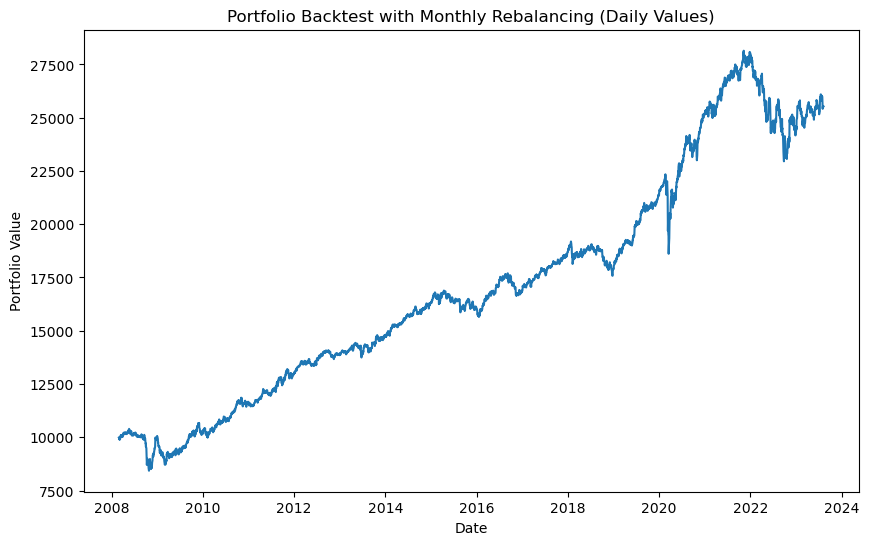

In [23]:
# Plot the portfolio value over time
plt.figure(figsize=(10, 6))
plt.plot(results_df.index, results_df['Cumulative'])
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.title('Portfolio Backtest with Monthly Rebalancing (Daily Values)')
plt.show()

<Axes: title={'center': 'Asset Weights'}>

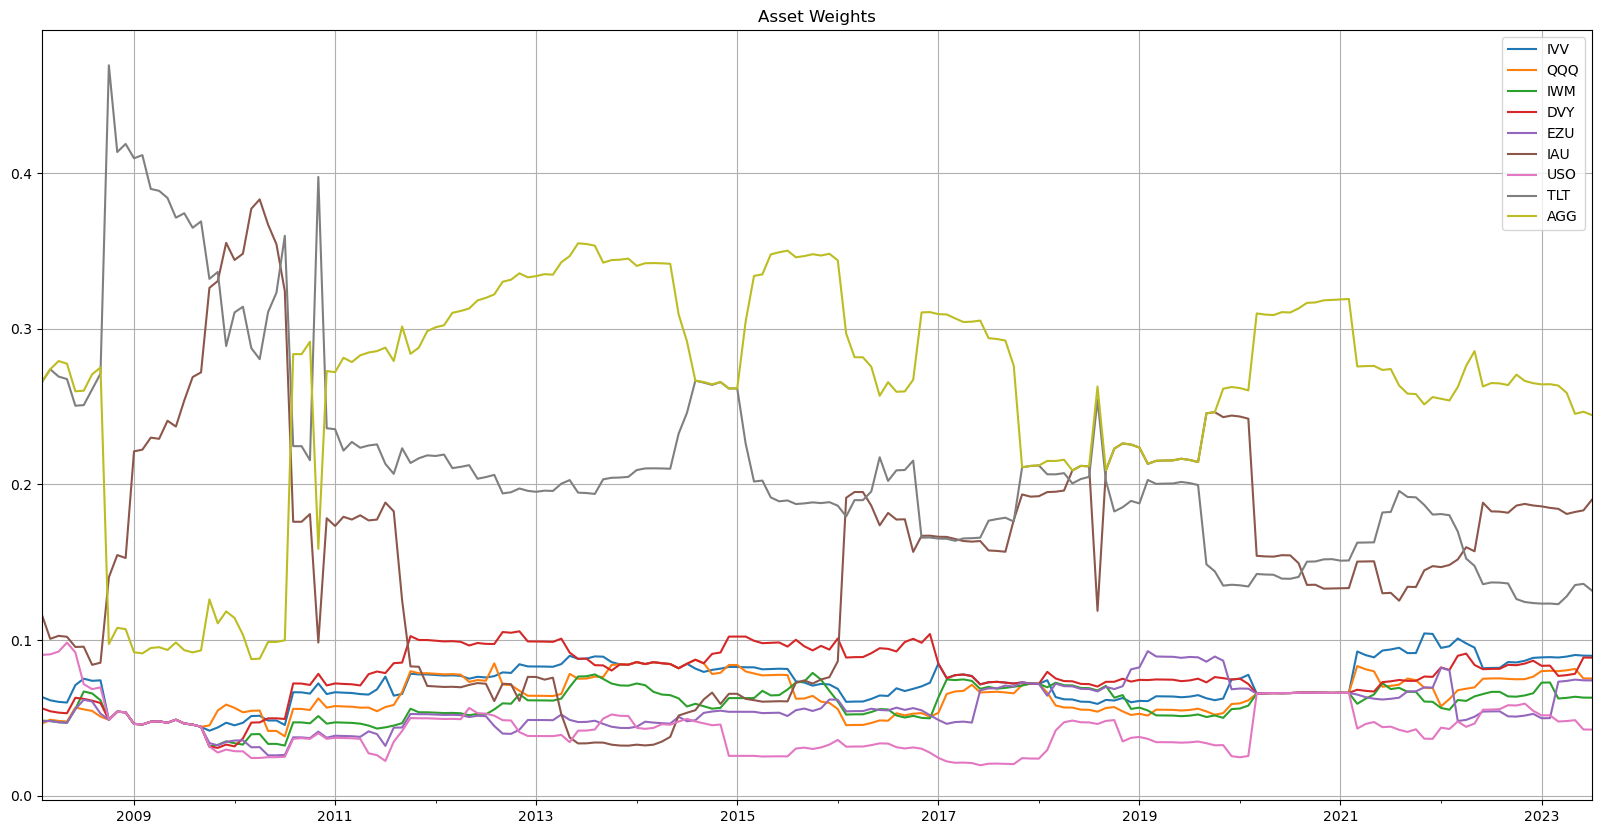

In [24]:
dfw_herc.plot(figsize=(20,10), grid=True, title='Asset Weights')

Equities
Commodities
FixedIncome


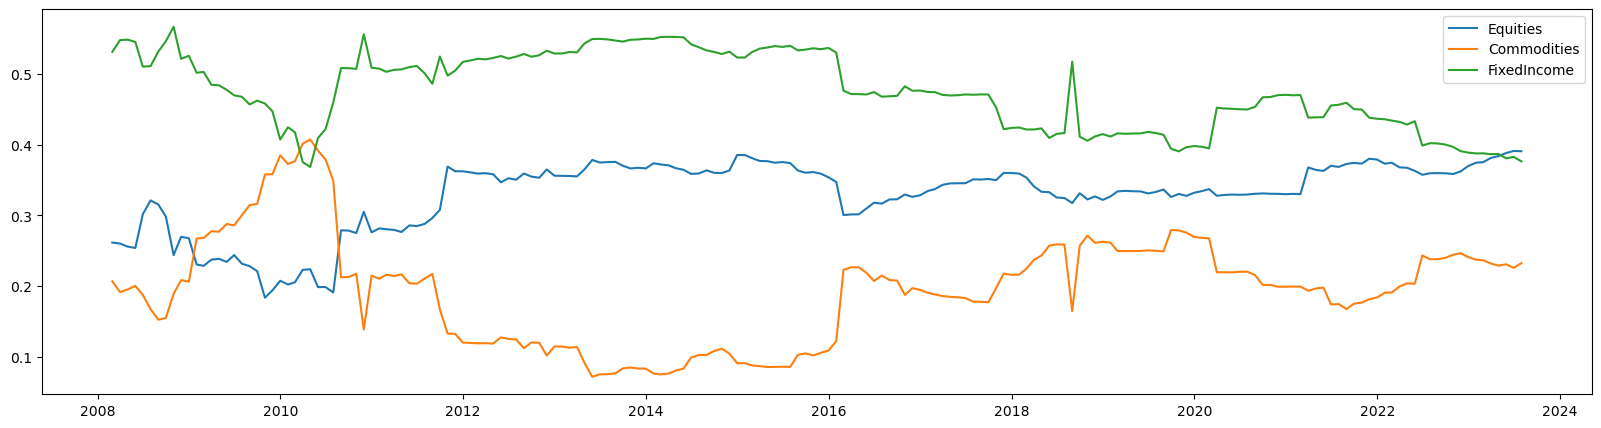

In [25]:
fig, ax = plt.subplots( figsize=(20,5))
for asset_class in universe.keys():
    print(asset_class)
    plt.plot(dfw_herc[universe[asset_class].keys()].sum(axis=1), label=asset_class)
plt.legend()

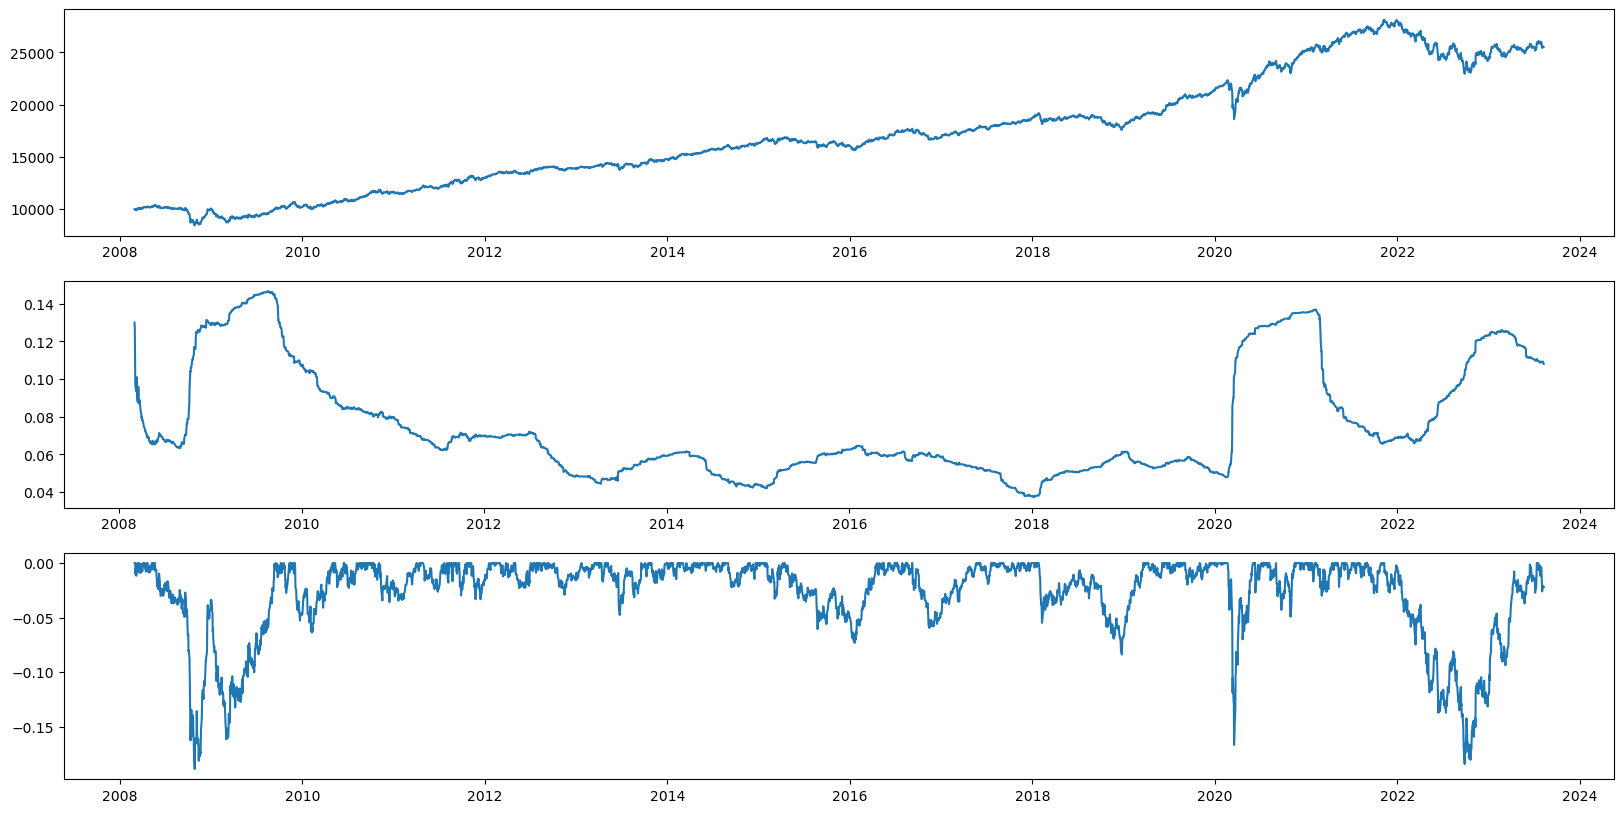

In [26]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
ax[0].plot(results_df['Cumulative'], label='Portfolio')
ax[1].plot(results_df['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252), label='Rolling STD')
ax[2].plot(results_df['Cumulative']/results_df['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='Rolling DD')

In [27]:
results_ivp = run_backtest(dfw_ivp, 10000)

In [28]:
print(results_df['Returns']['2008-06':].mean()/results_df['Returns']['2008-06':].std()*np.sqrt(252))
print(results_ivp['Returns']['2008-06':].mean()/results_ivp['Returns']['2008-06':].std()*np.sqrt(252))

0.7596982872502726
0.5220621636946265


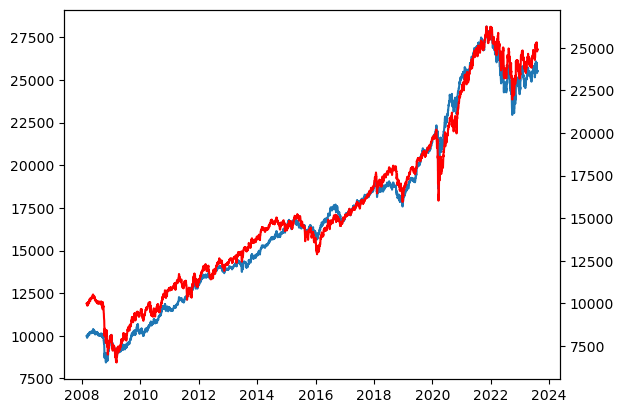

In [29]:
fig, ax = plt.subplots()
ax.plot(results_df['Cumulative'], label='HERC')
ax1 = ax.twinx()
ax1.plot(results_ivp['Cumulative'], label='IVP', color='red')

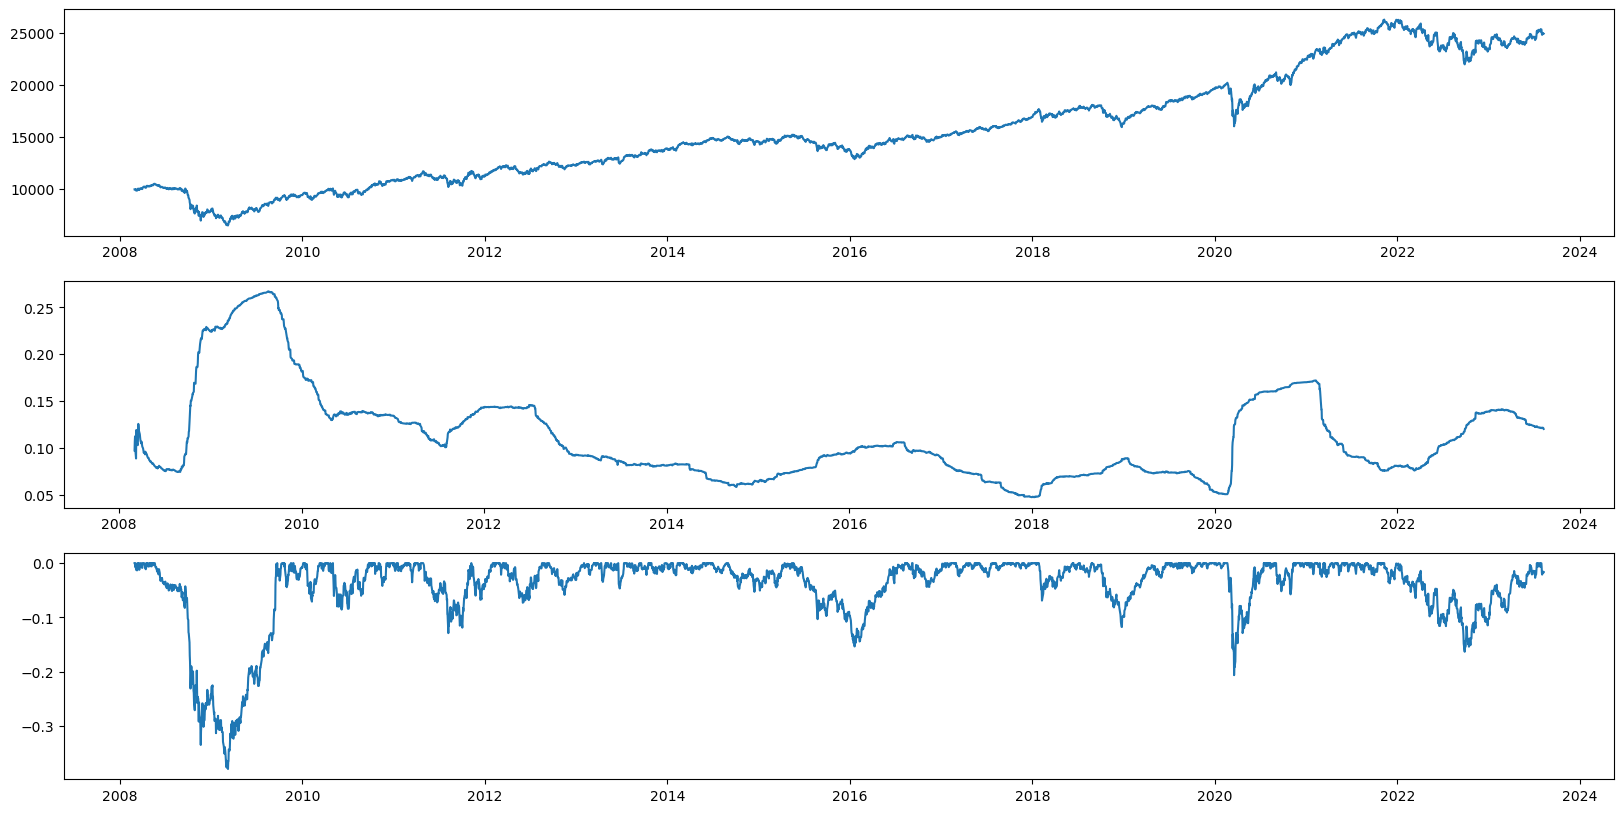

In [30]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
ax[0].plot(results_ivp['Cumulative'], label='Portfolio')
ax[1].plot(results_ivp['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252), label='Rolling STD')
ax[2].plot(results_ivp['Cumulative']/results_ivp['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='Rolling STD')

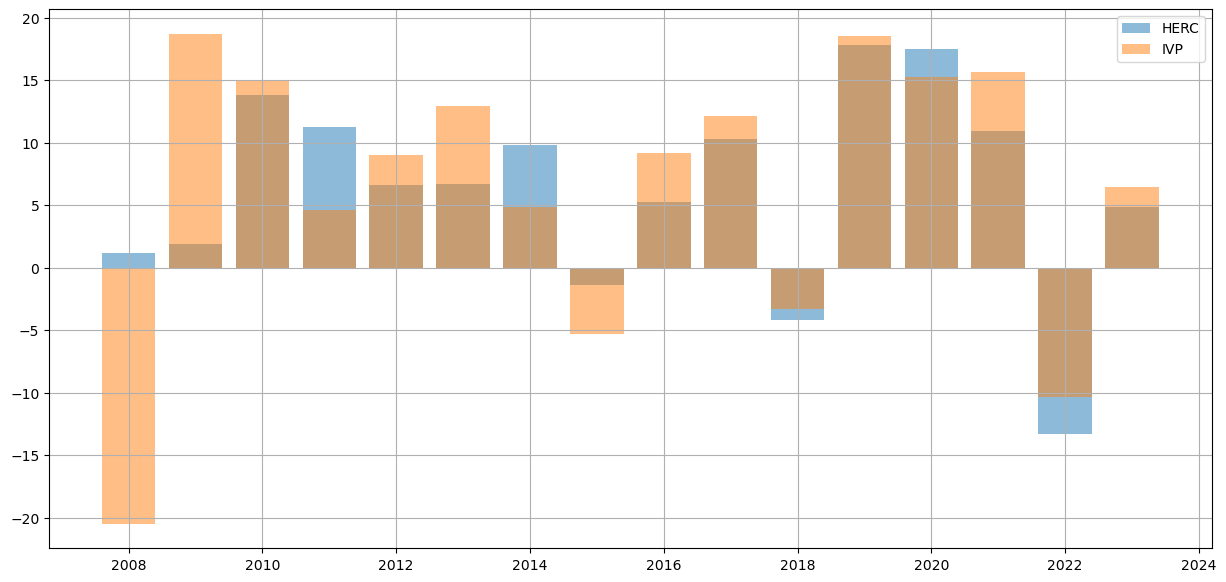

In [31]:
yearly_returns = ((results_df['Returns']).groupby([results_df['Returns'].index.year]).sum()*100)
yearly_returns_ivp = ((results_ivp['Returns']).groupby([results_ivp['Returns'].index.year]).sum()*100)
fig, ax = plt.subplots(figsize=(15,7))
ax.bar(yearly_returns.index, yearly_returns, label='HERC', alpha=0.5)
ax.bar(yearly_returns_ivp.index, yearly_returns_ivp, label='IVP', alpha=0.5)
plt.grid(True)
plt.legend()

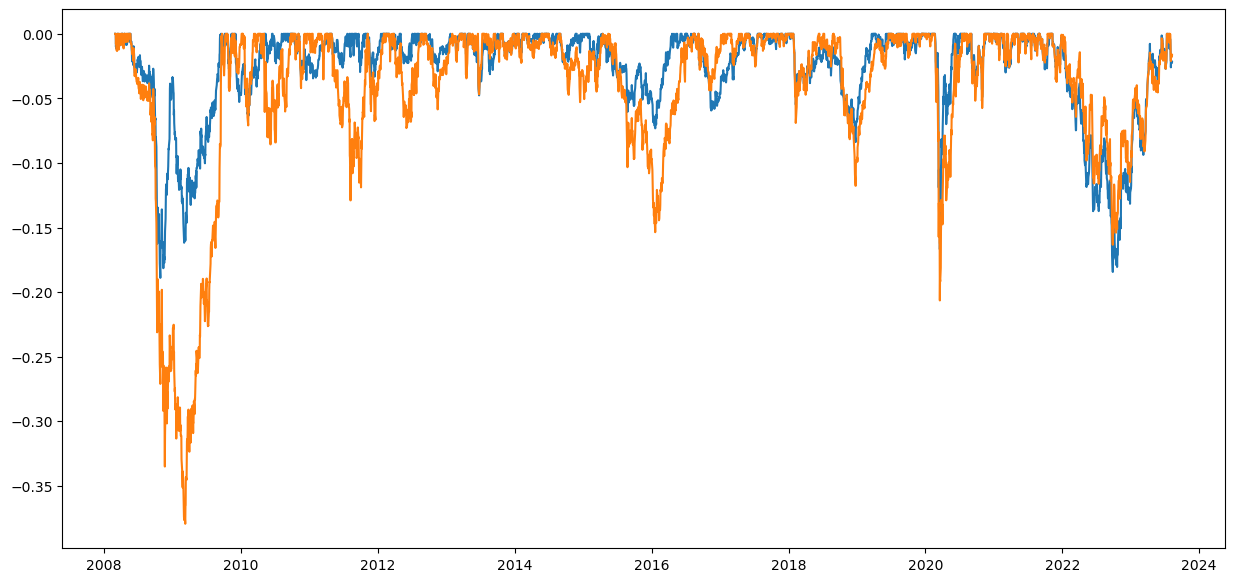

In [32]:
fig, ax = plt.subplots(figsize=(15,7))
ax.plot(results_df['Cumulative']/results_df['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='HERC')
ax.plot(results_ivp['Cumulative']/results_ivp['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='IVP')

In [33]:
# To do.
# 1. Momentum: momentum multiplier for each asset. Do Carvers EWAC, get scaled momentum, and then multiply weight by momentum factor on monthly basis?
# 2. Implement realistic trading costs
# 3. Currently doing daily rebalancing. Should do monthly rebalancing instead.


In [34]:
def ewmac_forecast_scalar(Lfast, Lslow):
    fsdict=dict(l2_8=10.6, l4_16=7.5, l8_32=5.3, l16_64=3.75, l32_128=2.65, l64_256=1.87)
    
    lkey="l%d_%d" % (Lfast, Lslow)
    
    if lkey in fsdict:
        return fsdict[lkey]
    else:
        print ("Warning: No scalar defined for Lfast=%d, Lslow=%d, using default of 1.0" % (Lfast, Lslow))
        return 1.0
   
def ewmac(price, Lfast=16):
    vol_lookback = 25
    
    Lslow=4*Lfast
    
    fast_ewma=price.ewm(span=Lfast).mean()
    slow_ewma=price.ewm(span=Lslow).mean()
    raw_ewmac=fast_ewma - slow_ewma
    
    stdev_returns=price.diff().ewm(span=vol_lookback).std()
    vol_adj_ewmac=raw_ewmac/stdev_returns
    
    f_scalar=ewmac_forecast_scalar(Lfast, Lslow)

    forecast=vol_adj_ewmac*f_scalar
    
    return (np.maximum(np.minimum(forecast, 20), -20)/2 + 10)/20

<Axes: >

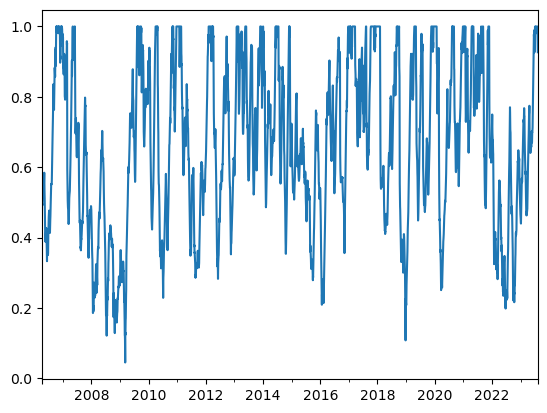

In [35]:
vol_adj_ewmac = ewmac(prices['IVV'])
vol_adj_ewmac.plot()

In [36]:
ewmacs = pd.DataFrame([ewmac(prices[symbol.ticker], Lfast=16) for symbol in tickers], index=symbols).T
ewmacs = ewmacs.resample('D').last().ffill().fillna(method='ffill').shift(1)
ewmacs_full = ewmacs.copy()

In [37]:
#ewmacs = pd.DataFrame(np.where(ewmacs < 0.5, 0.01, ewmacs), columns = symbols, index = ewmacs_full.index)

<Axes: title={'center': 'EWMACS'}>

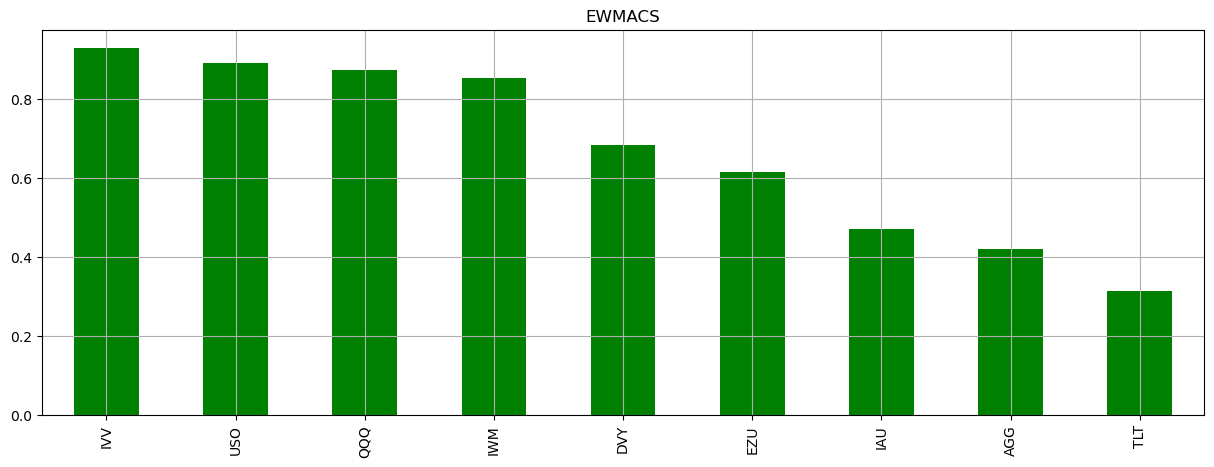

In [38]:
ewmacs.iloc[-1].sort_values(ascending=False).plot.bar(figsize=(15, 5), title='EWMACS', color='green', grid=True)

In [39]:
dfw_mom = dfw_herc * (ewmacs.loc[dfw_herc.index])
dfw_mom /= dfw_mom.sum(axis=1).values.reshape(-1,1)

<Axes: >

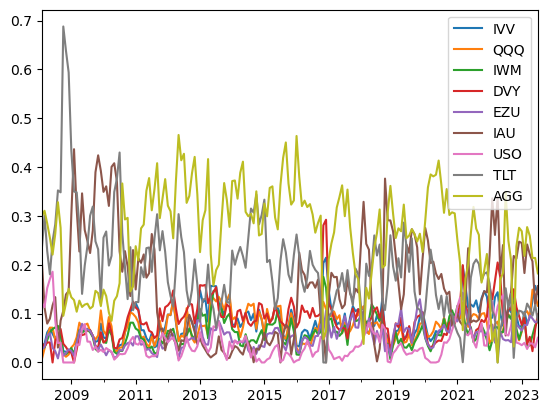

In [40]:
dfw_mom.plot()

In [41]:
results_mom = run_backtest(dfw_mom, 10000)

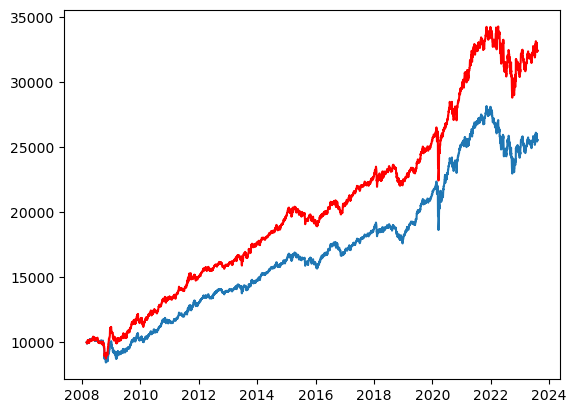

In [42]:
plt.plot(results_df.index, results_df['Cumulative'], label='HERC')
plt.plot(results_mom.index, results_mom['Cumulative'], label='HERC + Momentum', color='red');

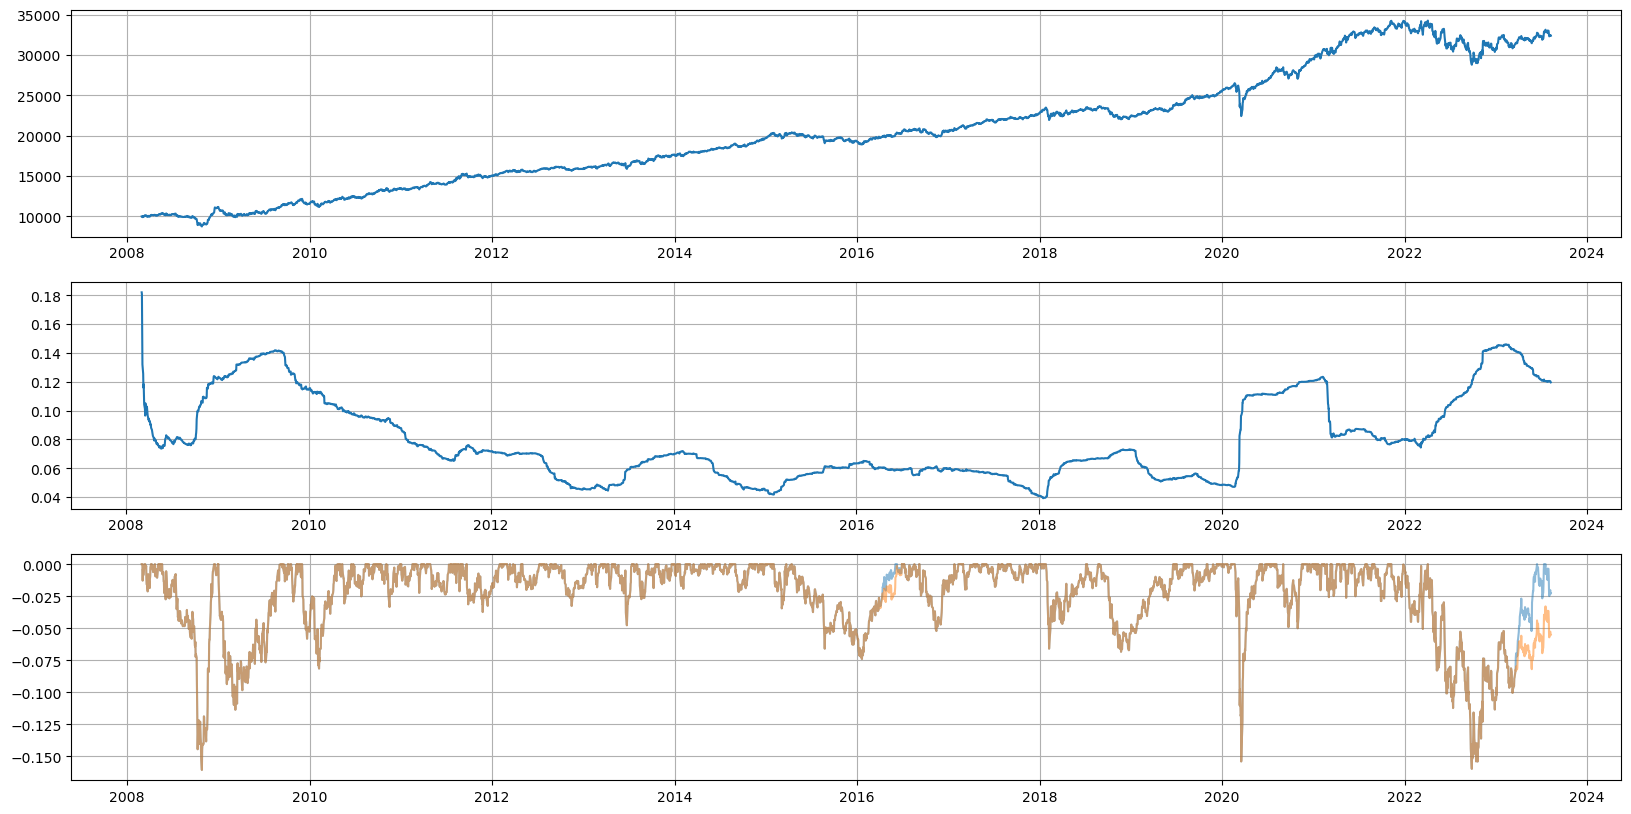

In [43]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(20,10))
ax[0].plot(results_mom['Cumulative'], label='Portfolio')
ax[1].plot(results_mom['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252), label='Rolling STD')
ax[2].plot(results_mom['Cumulative']/results_mom['Cumulative'].rolling(window=252, min_periods=1).max()-1, label='Rolling 1 Year DD', alpha=0.5)
ax[2].plot(results_mom['Cumulative']/results_mom['Cumulative'].expanding().max()-1, label='DD', alpha=0.5)

[ax[i].grid(True) for i in range(3)];

In [44]:
results_mom['Returns']['2008-06':].mean()/results_mom['Returns']['2008-06':].std()*np.sqrt(252)

0.9141748905649966

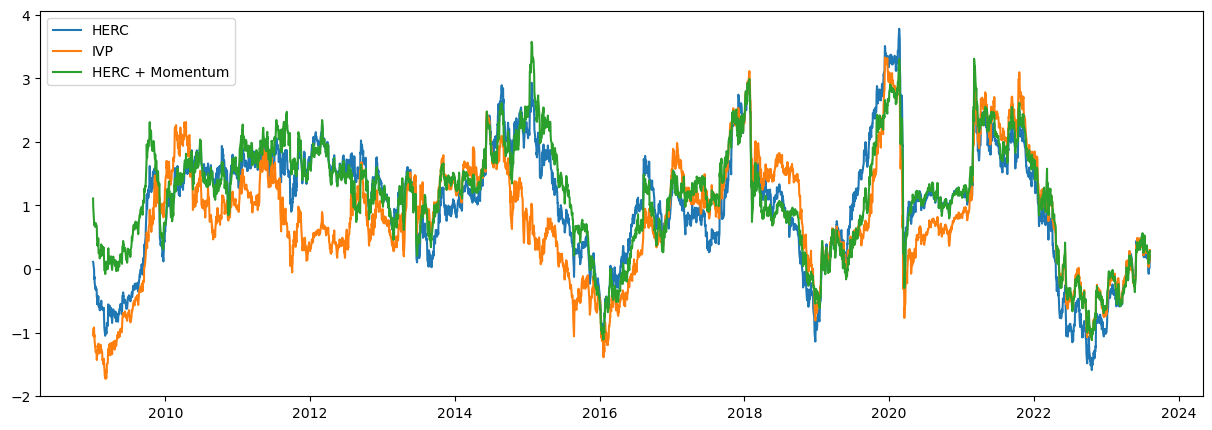

In [45]:
rolling_sharpe_herc = results_df['Returns'].rolling(window=252, min_periods=1).mean()/results_df['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252)
rolling_sharpe_ivp = results_ivp['Returns'].rolling(window=252, min_periods=1).mean()/results_ivp['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252)
rolling_sharpe_mom = results_mom['Returns'].rolling(window=252, min_periods=1).mean()/results_mom['Returns'].rolling(window=252, min_periods=1).std()*np.sqrt(252)
rolling_sharpe = pd.concat([rolling_sharpe_herc, rolling_sharpe_ivp, rolling_sharpe_mom], axis=1)
rolling_sharpe.columns = ['HERC', 'IVP', 'HERC + Momentum']
rolling_sharpe = rolling_sharpe['2009':]


fig, ax = plt.subplots(figsize=(15,5))
plt.plot(rolling_sharpe['HERC'], label='HERC')
plt.plot(rolling_sharpe['IVP'], label='IVP')
plt.plot(rolling_sharpe['HERC + Momentum'], label='HERC + Momentum')
plt.legend();

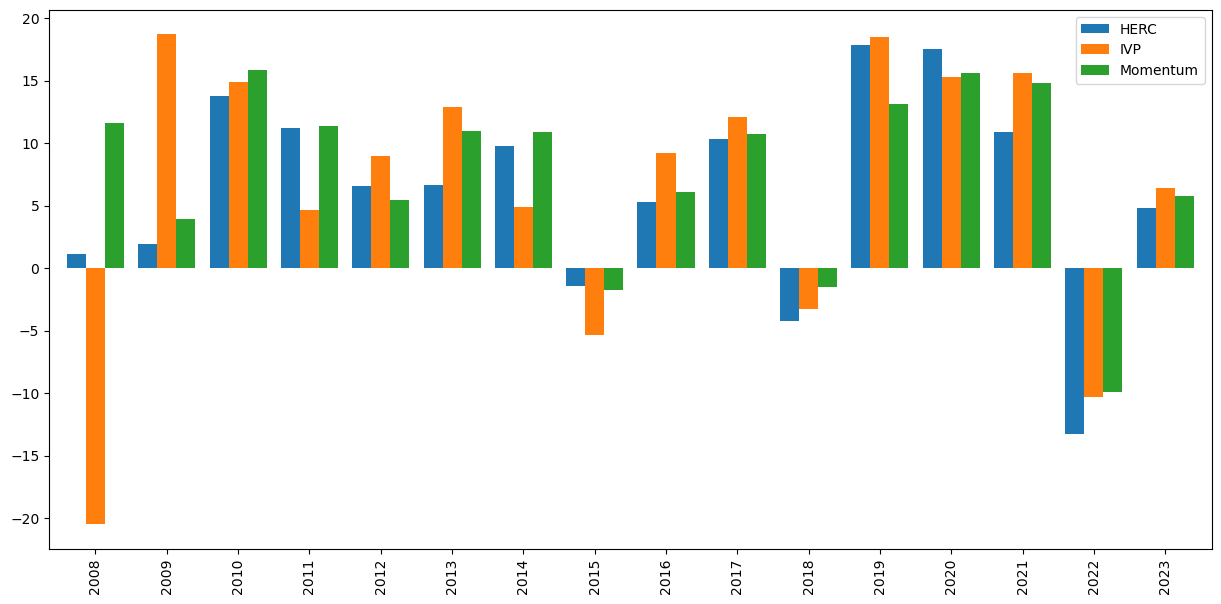

In [46]:
yearly_returns_mom = ((results_mom['Returns']).groupby([results_mom['Returns'].index.year]).sum()*100)
comb_returns = pd.concat([yearly_returns, yearly_returns_ivp, yearly_returns_mom], axis=1)
comb_returns.columns = ['HERC', 'IVP', 'Momentum']
comb_returns.plot(kind='bar', width=0.8, figsize=(15,7));

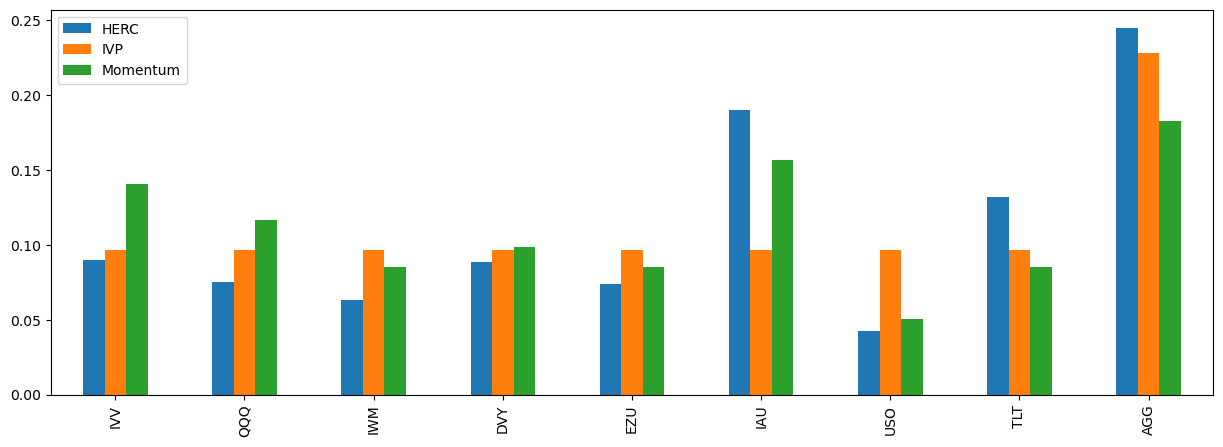

In [47]:
weight_comp = pd.concat([dfw_herc.iloc[-1],dfw_ivp.iloc[-1], dfw_mom.iloc[-1]], axis=1)
weight_comp.columns = ['HERC', 'IVP', 'Momentum']
weight_comp.plot(kind='bar', figsize=(15,5));


In [48]:
def cum_res_date(_df_in, date):
    _df_in = _df_in.loc[date:]
    _df_in/=_df_in.iloc[0]
    return _df_in

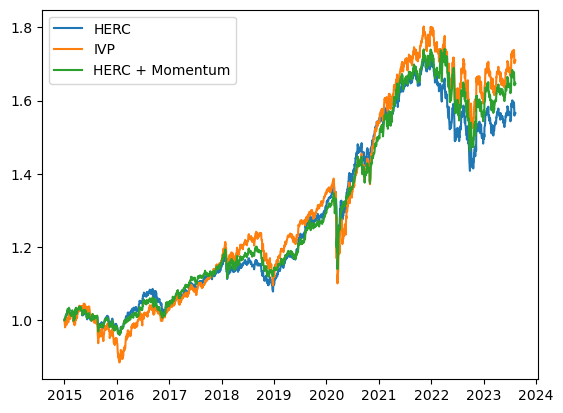

In [49]:
start_date = '2015'
plt.plot(cum_res_date(results_df['Cumulative'].copy(), start_date))
plt.plot(cum_res_date(results_ivp['Cumulative'].copy(), start_date))
plt.plot(cum_res_date(results_mom['Cumulative'].copy(), start_date))
plt.legend(['HERC', 'IVP', 'HERC + Momentum'])

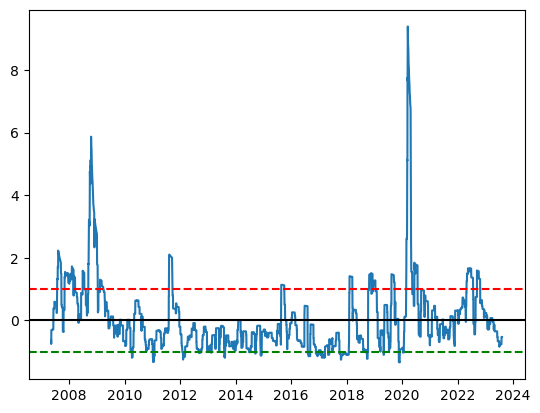

In [50]:
rolling_cvar = full_df['IVV'].pct_change().rolling(window=30).apply(rolling_cvar)
cvar_zscore = ((rolling_cvar - rolling_cvar.rolling(window=252*10, min_periods=252).mean())/rolling_cvar.rolling(window=252*10, min_periods=252).std())
plt.plot(cvar_zscore)
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')

In [51]:
from arch import arch_model
returns = 100*np.log(full_df['IVV']).diff().dropna()
model = arch_model(returns, vol="Garch", p=1, q=1)
results = model.fit()


Iteration:      1,   Func. Count:      6,   Neg. LLF: 4575999307.938018
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1440273786.3158655
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8606.829414797103
Iteration:      4,   Func. Count:     29,   Neg. LLF: 6257.714939376101
Iteration:      5,   Func. Count:     35,   Neg. LLF: 6085.276819606515
Iteration:      6,   Func. Count:     41,   Neg. LLF: 6260.512481981308
Iteration:      7,   Func. Count:     47,   Neg. LLF: 6069.466039764109
Iteration:      8,   Func. Count:     52,   Neg. LLF: 6069.460354771099
Iteration:      9,   Func. Count:     57,   Neg. LLF: 6069.449264213088
Iteration:     10,   Func. Count:     62,   Neg. LLF: 6069.449184481748
Iteration:     11,   Func. Count:     67,   Neg. LLF: 6069.449183230362
Iteration:     12,   Func. Count:     71,   Neg. LLF: 6069.449183230066
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6069.449183230362
            Iterations: 12


In [52]:
volatility = results.conditional_volatility


c:\Users\vwste\anaconda3\Lib\site-packages\arch\__future__\_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


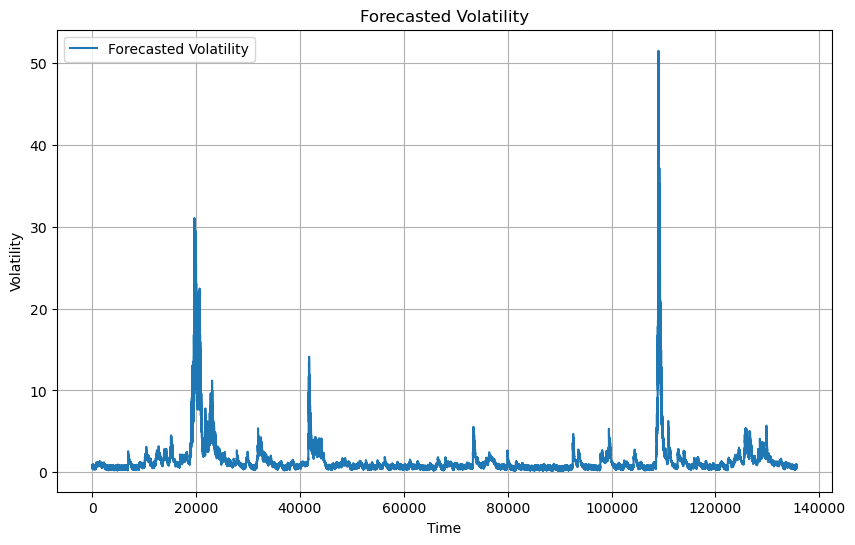

In [54]:
# Forecast the volatility
forecast = results.forecast(start=0, horizon=30)
forecast_volatility = forecast.variance.dropna().values.flatten()

# Plot the forecasted volatility
plt.figure(figsize=(10, 6))
plt.plot(forecast_volatility, label="Forecasted Volatility")
plt.xlabel("Time")
plt.ylabel("Volatility")
plt.title("Forecasted Volatility")
plt.legend()
plt.grid(True)

plt.show();

## Optimize Settings

In [55]:
def get_full_result(setting, use_setting_dict):
    
    if use_setting_dict:
        _cov_min = setting['cov_min']
        _cov_max = setting['cov_max']
        _risk_lookback =setting['risk_lookback']
        _w_method =setting['w_method']
        _max_k = setting['max_k']
        _min_risk = setting['min_risk']
        _max_risk = setting['max_risk']
        _return_lookback_years=setting['return_lookback_years']

    else:
        _cov_min = setting[0]*-1
        _cov_max = setting[0]
        _risk_lookback = setting[1]
        _w_method ='cvar'
        _max_k = setting[2]
        _min_risk = setting[3]
        _max_risk = setting[4]
        _return_lookback_years=setting[5]
            
    wfwds = [get_market_weights(d=d.date(), 
                        cov_min = _cov_min, 
                        cov_max = _cov_max,  
                        risk_lookback = _risk_lookback, 
                        w_method = _w_method, 
                        max_k = _max_k, 
                        min_risk = _min_risk, 
                        max_risk = _max_risk, 
                        return_lookback_years = _return_lookback_years) 
        for d in dates]

    dfw = pd.DataFrame([w[0] for w in wfwds], index=dates)   
    
    _wdf = dfw.resample('B').last().ffill()
    _wdf.columns = [col.replace('PRP ', '') for col in _wdf.columns]

    portfolio_returns = run_backtest(_wdf, 10000)
    
    return {'settings':setting, 'port_rets':portfolio_returns}

In [56]:
settings = {0: {'cov_min' : -1, 'cov_max' : 1, 'risk_lookback' : 52, 'w_method' : 'cvar', 'max_k' : 3, 'min_risk' : 2.5, 'max_risk' : 10, 'return_lookback_years': 10, 'height': 0.7, 'return_decay': None},
            1: {'cov_min' : -1.5, 'cov_max' : 1.5, 'risk_lookback' : 52, 'w_method' : 'cvar', 'max_k' : 3, 'min_risk' : 1.5, 'max_risk' : 10, 'return_lookback_years': 5, 'height': 0.7, 'return_decay': None},
            2: {'cov_min' : -1.25, 'cov_max' : 1.25, 'risk_lookback' : 52, 'w_method' : 'cvar', 'max_k' : 3, 'min_risk' : 1.5, 'max_risk' : 10, 'return_lookback_years': 5, 'height': 0.7, 'return_decay': None},
}

In [57]:
run_optimization = False
if run_optimization:
    settings_res_lim = [get_full_result(setting, True) for k,setting in settings.items()]

import multiprocessing
from multiprocessing import Pool

use_setting_dict=True
jobs = [(setting, use_setting_dict) for k,setting in settings.items()]
with Pool() as pool:
    settings_res_lim = pool.starmap(get_full_result, jobs)

In [58]:
if run_optimization:
    fig, ax = plt.subplots(figsize=(15,7))
    for i,r in enumerate(settings_res_lim):
        print(i, r['port_rets']['Returns'].mean()/r['port_rets']['Returns'].std()*np.sqrt(252))
        plt.plot(r['port_rets']['Cumulative'], label=i)
    plt.legend()